### TFG AÑO- Cesar Hernandez Rodriguez
El estudio se hace con los datos historicos de año a año (252 dias), se realiza la prediccion de ciertos activos elegidos previamente, si se necesita cualquier otro activo del NASDAQ estan en los otros script ya que esto solo es una pequeña muestra representativa del funcionamiento

Este script se basa en descargar datos de la bolsa de EEUU, exactamente todos los del índice NASDAQ que es uno de los índices más importantes de Estados Unidos (índide tecnologico), siendo la segunda bolsa de valores automatizada y electronica mas grande del mundo con 3800 compañias. (https://es.wikipedia.org/wiki/NASDAQ)

De este conjunto de datos solo voy a coger son $['AAPL', 'SNRC', 'ATVI', 'MINI', 'GOOG', 'BBOX']$ 

Para ello usaré la librería QUANDL (https://www.quandl.com/tools/python) que implementa una API para poder descargar los datos de manera sencilla. Al crearme una cuenta gratuita las opciones que se ofrecen no son las mias que para una cuenata premium por lo que cogere fechas pasadas y no actuales. 

A mayores una vez descagardo los datos (ya que tarda mucho) los voy a guardar dentro de mi ordenador serializandolo con el paquete Pickle (http://pyspanishdoc.sourceforge.net/lib/module-pickle.html)

A la hora de realizar el modelo creo 3 atributos, 2 medias moviles una de 10 dias y otra de 20 dias y un oscilador de la media movil de 20 dias.

Depues de realizar el modelo la idea de la practica es realizar una prueba real, por ello me fio del modelo que he obtenido e imaginando una inversion inical de 100000 euros dejo que la red neuronal haga lo que deba con ese dinero, decidiendo si quiere comprar, vender o mantener. Hay 3 formas programadas, compra a la alza, compra a la alza y a la baja y compra a la baja.

In [6]:
# Import predefinifods
import pandas as pd
import numpy as np
import random
from math import *
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from time import time
import matplotlib.pyplot as plt

# Importa descaga de datos
import quandl

# Import serializar
import pickle

# Import red Neuronal
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
import keras.backend as K

# Conteo
from collections import Counter

# Graficos
#plt.style.use('fivethirtyeight')
#plt.style.use('dark_background')
plt.style.use('seaborn')

In [7]:
# Descarga de las bases los tickets de los activos que vamos a predecir con los csv de la carpeta
def get_tickers_sample_nasdaq():
    tickers_wiki_quandl = pd.read_csv('WIKI_PRICES.csv')['ticker']
    tickers_nasdaq = pd.read_csv('nasdaq-listed-symbols-TFG.csv')
    
    tickersQuandl = []    
    tickers = pd.DataFrame(columns = ['Symbol','CompanyName'], index = range(len(tickers_nasdaq)))

    for i in range(len(tickers_nasdaq)):
        word = tickers_nasdaq['Symbol'][i]
        for j in range(len(tickers_wiki_quandl)):
            if word == tickers_wiki_quandl[j]:
                tickers['Symbol'][i] = word
                tickers['CompanyName'][i] = tickers_nasdaq['CompanyName'][i]
    
    for tick in tickers['Symbol']:
        tickersQuandl.append("WIKI/"+tick)
    
    return tickers, tickersQuandl

#a,b = get_tickers_sample_nasdaq()

In [26]:
# Descargo de los datos con la API Quandl y la key propia
# Las fechas estan elegidas a convinencia para poder concatenar las fechas y que quede de seguido

def get_data(verbose):
    quandl.ApiConfig.api_key = 'WgQVD8Npfox1MN7SV3Nm'
    tickers, tickersQuandl = get_tickers_sample_nasdaq()
    
    if verbose: print(" ****Empezamos a descargar los datos****\n")
    
    datos = {}
    start_time = time()
    long = len(tickersQuandl)
    i = 0
    # Las fechas elegidas son esas para poder tener una gran cantidad de datos historicos y
    # que justo se complementen con las fechas de tipo test, al hacer Medias Moviles se pierden muchos datos
    for ticker in tickersQuandl:
        if i % 2 == 0 and verbose: print("LLeva descargados el ",i/long *100,"% de los datos")
        #aux=quandl.get(ticker,start_date="2000-01-01",end_date="2016-12-31")
        aux=quandl.get(ticker,start_date="2009-01-01",end_date="2016-12-31")
        datos[ticker[5:len(ticker)]] = aux
        i = i + 1
    
    datosClose = {}
    for key in datos:
        datosClose[key] = datos[key]["Adj. Close"]
    
    elapsed_time = time() - start_time
    if verbose: print("\nHa tardado en descargar los datos: %0.10f segundos." % elapsed_time)
    
    if verbose: print("\n ****Empezamos a descargar los datos test****\n")
    
    # Procedo a hacer las mismas operaciones para el conjunto TEST
    datos_test = {}
    i = 0
    long = len(tickersQuandl)
    start_time = time()    
    for ticker in tickersQuandl:
        if i % 2 == 0 and verbose: print("LLeva descargados el ",i/long *100,"% de los datos test")
        aux=quandl.get(ticker,start_date="2015-12-02",end_date="2020-12-31")
        datos_test[ticker[5:len(ticker)]] = aux
        i = i + 1
    
    datosClose_test = {}
    for key in datos_test:
        datosClose_test[key] = datos_test[key]["Adj. Close"]
    
        elapsed_time = time() - start_time
    if verbose: print("\nHa tardado en descargar los datos test: %0.10f segundos." % elapsed_time)
    if verbose: print("\n")
    
    # Guardamos los datos y serializamos
    pickle.dump(tickers, open("datos_demo/tickers_nasdaq.p", "wb"))
    pickle.dump(tickersQuandl, open("datos_demo/tickersQuandl_nasdaq.p", "wb"))
    pickle.dump(datos, open("datos_demo/nasdaq.p", "wb"))
    pickle.dump(datosClose, open("datos_demo/nasdaqClose.p", "wb"))
    pickle.dump(datos_test, open("datos_demo/nasdaq_testAño.p", "wb"))
    pickle.dump(datosClose_test, open("datos_demo/nasdaqClose_testAño.p", "wb"))
    
    return tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test

In [27]:
# Si los datos ya han sido descargados con esta funcion los cargo gracias a la libreria pickles
def get_data_load(verbose):
    if verbose: print(" ****Empezamos a cargar los datos****\n")
    tickers = pickle.load(open("datos_demo/tickers_nasdaq.p", "rb" ))
    tickersQuandl = pickle.load(open("datos_demo/tickersQuandl_nasdaq.p", "rb" ))
    datos = pickle.load(open("datos_demo/nasdaq.p", "rb" ))
    datosClose = pickle.load(open("datos_demo/nasdaqClose.p", "rb" ))
    if verbose: print(" ****Cargados los datos****\n")
    
    if verbose: print("\n ****Empezamos a cargar los datos test****\n")
    datos_test = pickle.load(open("datos_demo/nasdaq_testAño.p", "rb" ))
    datosClose_test = pickle.load(open("datos_demo/nasdaqClose_testAño.p", "rb" ))
    if verbose: print(" ****Cargados los datos test****\n")
    
    return tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test

# Para imprimir cualquier conjunto tipo Serie temporal del conjunto de datos base uso esta funcion
def plot_datos(datosClose,nombre,test):
    datosClose[nombre['Symbol']].plot(figsize=(12,5),grid=True)
    plt.title('{} de la compañia {} {}\n'.format(nombre['Symbol'],nombre['CompanyName'],test))
    plt.ylabel('Precio de Cierre')
    plt.xlabel('Fecha')
    plt.show()
    

In [28]:
datos_descargados = False
if datos_descargados:
    tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test= get_data_load(True)
else : 
    tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test = get_data(True)

 ****Empezamos a descargar los datos****

LLeva descargados el  0.0 % de los datos
LLeva descargados el  33.33333333333333 % de los datos
LLeva descargados el  66.66666666666666 % de los datos

Ha tardado en descargar los datos: 10.0816776752 segundos.

 ****Empezamos a descargar los datos test****

LLeva descargados el  0.0 % de los datos test
LLeva descargados el  33.33333333333333 % de los datos test
LLeva descargados el  66.66666666666666 % de los datos test

Ha tardado en descargar los datos test: 4.1301684380 segundos.




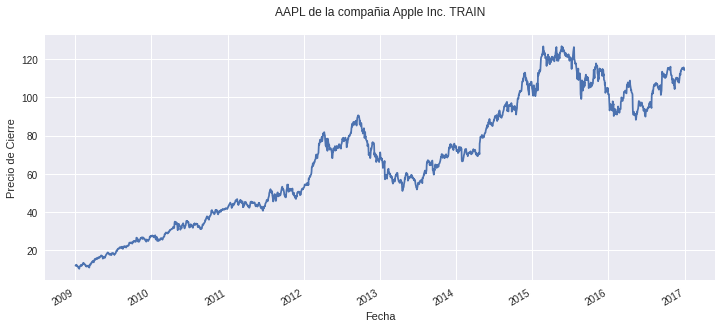

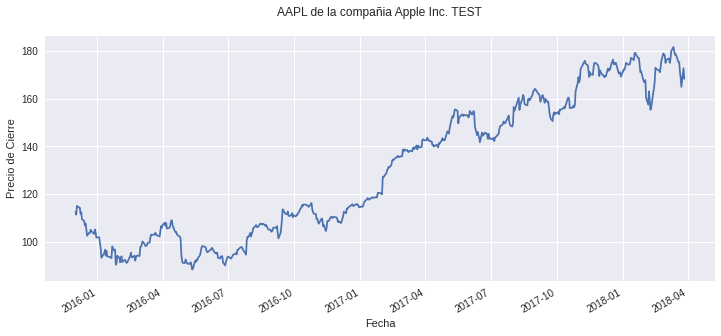

In [30]:
# Grafico un activo aleatorio 
# Se tiene el gráfico con el que se creara el modelo y los datos sobre los que se va a testear
ran = 0
plot_datos(datosClose,tickers.iloc[ran],"TRAIN")
plot_datos(datosClose_test,tickers.iloc[ran],"TEST")

In [31]:
# Creacion de los atributos para la Red Neuronal Recurrente
def differences(x):
    return x[-1] - x[0]

def create_features(datosClose,days1,days2):
    X = pd.DataFrame()
    data = pd.DataFrame()
    data['Adj. Close'] = datosClose.values
    
    indices = datosClose.index
    
    X['MA_{}'.format(days1)] = data['Adj. Close'].rolling(window=days1).mean()
    X['MA_{}'.format(days2)] = data['Adj. Close'].rolling(window=days2).mean()
    X['Diferencia'] = data['Adj. Close'].rolling(window=days2).apply(differences,raw=True) 
    X = X[days2:len(X)-1].reset_index()
    X.drop(['index'], axis='columns', inplace=True)

    return X, indices[(days2+1):len(indices)]

# Creo tambien timestep de 30 dias (igual que la media movil) para la RED NEURONAL
def cut_timestep(x,y,time):
    
    Xt = []
    yt = []
    index_time = []

    for i in range(timeStep, len(x)):
        Xt.append(x[i-timeStep:i,:])
        yt.append(y.iloc[i,0])
        index_time.append(time[i])

    return np.array(Xt), np.array(yt), pd.Series(index_time)

In [32]:
# A parte de la creacion de atributos
index = ran
timeStep = 252 # longitud de secuencias que se hacen en cada iteracion de la red (un año entero)

# Extraigo los atributos de los datos y los preparo para meterlos a la red neuronal

X, ind_time = create_features(datosClose[tickers['Symbol'][index]],10,20)
Y = pd.DataFrame(datosClose[tickers['Symbol'][index]].values[21:len(datosClose[tickers['Symbol'][index]])])
X = X.to_numpy()

# Creamos los atributos para los datos test
ticket_uso = tickers['Symbol'][index]
Xtesteo, ind_time_t = create_features(datosClose_test[tickers['Symbol'][index]],10,20)
Ytesteo = pd.DataFrame(datosClose_test[tickers['Symbol'][index]].values[21:len(datosClose_test[tickers['Symbol'][index]])])
Xtesteo = Xtesteo.to_numpy()

# Junto todos los datos para poder hacer su correcta normalizacion
X_aux = np.concatenate((X,Xtesteo),axis=0)

scaler = MinMaxScaler()
X_aux_scaled = scaler.fit_transform(X_aux)
X_scaled = X_aux_scaled[0:len(X)]
Xtesteo_scaled = X_aux_scaled[len(X):len(X_aux_scaled)]

# Creacion de los timestep
Xt, yt, index_time = cut_timestep(X_scaled,Y,ind_time)
Xtt, ytt, index_time_t = cut_timestep(Xtesteo_scaled,Ytesteo,ind_time_t)

# Split de en conjunto de prueba y entrenamiento para la red neuronal
P=yt.shape[0]
indices=np.arange(P,dtype=int)
np.random.shuffle(indices)
sequences_train=indices[0:int(P*2/3)]
sequences_test=indices[int(P*2/3):]
X_train, X_test, y_train, y_test = Xt[sequences_train],Xt[sequences_test],yt[sequences_train],yt[sequences_test]


print("Voy a predecir el activo {} de la compañia {}".format(ticket_uso,tickers['CompanyName'][index]))

Voy a predecir el activo AAPL de la compañia Apple Inc.


In [34]:
# Calculates a successfull ratio using less relative error than a maximum
def porcentaje_margen(y_true, y_pred):
    margen = 0.05
    yy = K.sum(K.cast(K.less(K.abs((y_pred/y_true)-1.0), margen), dtype=float))
    return yy/K.cast(K.shape(y_pred)[0], dtype=float)

# Creacion de la red neural LSTM

In [10]:
model42 = Sequential()
model42.add(LSTM(4, input_shape=(252,3),return_sequences=True))
model42.add(LSTM(units = 2,return_sequences = False))
model42.add(Dense(1)) 
model42.compile(optimizer="adam",loss='mse',metrics=[porcentaje_margen]) 
model42.summary()
history_LSTM42 = model42.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 252, 4)            128       
_________________________________________________________________
lstm_1 (LSTM)                (None, 2)                 56        
_________________________________________________________________
dense (Dense)                (None, 1)                 3         
Total params: 187
Trainable params: 187
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
37/37 [==============================] - 11s 309ms/step - loss: 6348.4204 - porcentaje_margen: 0.0000e+00 - val_loss: 6467.9570 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
37/37 [==============================] - 10s 280ms/step - loss: 6313.1782 - porcentaje_margen: 0.0000e+00 - val_loss: 6427.9585 - val_porcentaje_margen: 0.0000e+00
Epoch 3/1500
37/37 [==============

Epoch 43/1500
37/37 [==============================] - 13s 342ms/step - loss: 5330.7188 - porcentaje_margen: 0.0000e+00 - val_loss: 5452.6865 - val_porcentaje_margen: 0.0000e+00
Epoch 44/1500
37/37 [==============================] - 13s 341ms/step - loss: 5315.7168 - porcentaje_margen: 0.0000e+00 - val_loss: 5437.5034 - val_porcentaje_margen: 0.0000e+00
Epoch 45/1500
37/37 [==============================] - 13s 344ms/step - loss: 5300.7339 - porcentaje_margen: 0.0000e+00 - val_loss: 5422.4424 - val_porcentaje_margen: 0.0000e+00
Epoch 46/1500
37/37 [==============================] - 13s 340ms/step - loss: 5285.7710 - porcentaje_margen: 0.0000e+00 - val_loss: 5407.3247 - val_porcentaje_margen: 0.0000e+00
Epoch 47/1500
37/37 [==============================] - 13s 345ms/step - loss: 5270.8472 - porcentaje_margen: 0.0000e+00 - val_loss: 5392.3267 - val_porcentaje_margen: 0.0000e+00
Epoch 48/1500
37/37 [==============================] - 13s 345ms/step - loss: 5256.0161 - porcentaje_margen: 0

37/37 [==============================] - 13s 340ms/step - loss: 4679.5459 - porcentaje_margen: 0.0000e+00 - val_loss: 4796.9077 - val_porcentaje_margen: 0.0000e+00
Epoch 90/1500
37/37 [==============================] - 13s 339ms/step - loss: 4666.1929 - porcentaje_margen: 0.0000e+00 - val_loss: 4783.3213 - val_porcentaje_margen: 0.0000e+00
Epoch 91/1500
37/37 [==============================] - 13s 339ms/step - loss: 4652.8047 - porcentaje_margen: 0.0000e+00 - val_loss: 4769.8838 - val_porcentaje_margen: 0.0000e+00
Epoch 92/1500
37/37 [==============================] - 12s 331ms/step - loss: 4639.4907 - porcentaje_margen: 0.0000e+00 - val_loss: 4756.5308 - val_porcentaje_margen: 0.0000e+00
Epoch 93/1500
37/37 [==============================] - 13s 342ms/step - loss: 4626.2773 - porcentaje_margen: 0.0000e+00 - val_loss: 4743.1611 - val_porcentaje_margen: 0.0000e+00
Epoch 94/1500
37/37 [==============================] - 12s 337ms/step - loss: 4612.9800 - porcentaje_margen: 0.0000e+00 - va

Epoch 135/1500
37/37 [==============================] - 12s 327ms/step - loss: 4092.3086 - porcentaje_margen: 0.0000e+00 - val_loss: 4204.8784 - val_porcentaje_margen: 0.0000e+00
Epoch 136/1500
37/37 [==============================] - 12s 330ms/step - loss: 4080.1672 - porcentaje_margen: 0.0000e+00 - val_loss: 4192.6289 - val_porcentaje_margen: 0.0000e+00
Epoch 137/1500
37/37 [==============================] - 12s 332ms/step - loss: 4067.9978 - porcentaje_margen: 0.0000e+00 - val_loss: 4180.2017 - val_porcentaje_margen: 0.0000e+00
Epoch 138/1500
37/37 [==============================] - 12s 334ms/step - loss: 4055.7893 - porcentaje_margen: 0.0000e+00 - val_loss: 4167.9658 - val_porcentaje_margen: 0.0000e+00
Epoch 139/1500
37/37 [==============================] - 12s 328ms/step - loss: 4043.6716 - porcentaje_margen: 0.0000e+00 - val_loss: 4155.8359 - val_porcentaje_margen: 0.0000e+00
Epoch 140/1500
37/37 [==============================] - 12s 324ms/step - loss: 4031.6379 - porcentaje_mar

Epoch 181/1500
37/37 [==============================] - 12s 325ms/step - loss: 3557.2339 - porcentaje_margen: 0.0000e+00 - val_loss: 3664.9268 - val_porcentaje_margen: 0.0000e+00
Epoch 182/1500
37/37 [==============================] - 12s 319ms/step - loss: 3546.1870 - porcentaje_margen: 0.0000e+00 - val_loss: 3653.8398 - val_porcentaje_margen: 0.0000e+00
Epoch 183/1500
37/37 [==============================] - 12s 323ms/step - loss: 3535.1851 - porcentaje_margen: 0.0000e+00 - val_loss: 3642.6377 - val_porcentaje_margen: 0.0000e+00
Epoch 184/1500
37/37 [==============================] - 12s 322ms/step - loss: 3524.1404 - porcentaje_margen: 0.0000e+00 - val_loss: 3631.6389 - val_porcentaje_margen: 0.0000e+00
Epoch 185/1500
37/37 [==============================] - 12s 325ms/step - loss: 3513.1609 - porcentaje_margen: 0.0000e+00 - val_loss: 3620.4922 - val_porcentaje_margen: 0.0000e+00
Epoch 186/1500
37/37 [==============================] - 12s 325ms/step - loss: 3502.1899 - porcentaje_mar

Epoch 276/1500
37/37 [==============================] - 11s 302ms/step - loss: 2609.2749 - porcentaje_margen: 0.0389 - val_loss: 2707.2688 - val_porcentaje_margen: 0.0664
Epoch 277/1500
37/37 [==============================] - 11s 305ms/step - loss: 2600.4065 - porcentaje_margen: 0.0465 - val_loss: 2698.2715 - val_porcentaje_margen: 0.0714
Epoch 278/1500
37/37 [==============================] - 11s 309ms/step - loss: 2591.5681 - porcentaje_margen: 0.0439 - val_loss: 2689.4307 - val_porcentaje_margen: 0.0730
Epoch 279/1500
37/37 [==============================] - 11s 307ms/step - loss: 2582.7959 - porcentaje_margen: 0.0456 - val_loss: 2680.4546 - val_porcentaje_margen: 0.0747
Epoch 280/1500
37/37 [==============================] - 11s 310ms/step - loss: 2574.0413 - porcentaje_margen: 0.0456 - val_loss: 2671.6448 - val_porcentaje_margen: 0.0747
Epoch 281/1500
37/37 [==============================] - 12s 312ms/step - loss: 2565.2727 - porcentaje_margen: 0.0481 - val_loss: 2662.7014 - val_

Epoch 324/1500
37/37 [==============================] - 12s 313ms/step - loss: 2209.4631 - porcentaje_margen: 0.0118 - val_loss: 2302.5701 - val_porcentaje_margen: 0.0253
Epoch 325/1500
37/37 [==============================] - 11s 308ms/step - loss: 2201.6726 - porcentaje_margen: 0.0135 - val_loss: 2294.6428 - val_porcentaje_margen: 0.0253
Epoch 326/1500
37/37 [==============================] - 11s 306ms/step - loss: 2193.8748 - porcentaje_margen: 0.0127 - val_loss: 2286.8245 - val_porcentaje_margen: 0.0237
Epoch 327/1500
37/37 [==============================] - 11s 310ms/step - loss: 2186.1768 - porcentaje_margen: 0.0127 - val_loss: 2278.9966 - val_porcentaje_margen: 0.0253
Epoch 328/1500
37/37 [==============================] - 12s 315ms/step - loss: 2178.4038 - porcentaje_margen: 0.0118 - val_loss: 2271.0825 - val_porcentaje_margen: 0.0253
Epoch 329/1500
37/37 [==============================] - 12s 313ms/step - loss: 2170.6421 - porcentaje_margen: 0.0127 - val_loss: 2263.2388 - val_

Epoch 372/1500
37/37 [==============================] - 11s 305ms/step - loss: 1861.7461 - porcentaje_margen: 0.0642 - val_loss: 1950.0923 - val_porcentaje_margen: 0.0493
Epoch 373/1500
37/37 [==============================] - 11s 304ms/step - loss: 1855.0890 - porcentaje_margen: 0.0633 - val_loss: 1943.2858 - val_porcentaje_margen: 0.0461
Epoch 374/1500
37/37 [==============================] - 11s 305ms/step - loss: 1848.4093 - porcentaje_margen: 0.0642 - val_loss: 1936.4524 - val_porcentaje_margen: 0.0477
Epoch 375/1500
37/37 [==============================] - 11s 304ms/step - loss: 1841.7097 - porcentaje_margen: 0.0650 - val_loss: 1929.6416 - val_porcentaje_margen: 0.0493
Epoch 376/1500
37/37 [==============================] - 11s 309ms/step - loss: 1835.0043 - porcentaje_margen: 0.0676 - val_loss: 1922.9298 - val_porcentaje_margen: 0.0526
Epoch 377/1500
37/37 [==============================] - 11s 304ms/step - loss: 1828.4609 - porcentaje_margen: 0.0701 - val_loss: 1916.1442 - val_

Epoch 420/1500
37/37 [==============================] - 11s 303ms/step - loss: 1565.4774 - porcentaje_margen: 0.0583 - val_loss: 1648.9596 - val_porcentaje_margen: 0.0493
Epoch 421/1500
37/37 [==============================] - 11s 306ms/step - loss: 1559.8765 - porcentaje_margen: 0.0583 - val_loss: 1643.3446 - val_porcentaje_margen: 0.0493
Epoch 422/1500
37/37 [==============================] - 11s 301ms/step - loss: 1554.2946 - porcentaje_margen: 0.0566 - val_loss: 1637.5929 - val_porcentaje_margen: 0.0461
Epoch 423/1500
37/37 [==============================] - 11s 309ms/step - loss: 1548.6644 - porcentaje_margen: 0.0524 - val_loss: 1631.9568 - val_porcentaje_margen: 0.0444
Epoch 424/1500
37/37 [==============================] - 11s 305ms/step - loss: 1543.1221 - porcentaje_margen: 0.0549 - val_loss: 1626.2521 - val_porcentaje_margen: 0.0461
Epoch 425/1500
37/37 [==============================] - 11s 303ms/step - loss: 1537.5740 - porcentaje_margen: 0.0541 - val_loss: 1620.5916 - val_

Epoch 468/1500
37/37 [==============================] - 11s 303ms/step - loss: 1320.0546 - porcentaje_margen: 0.0557 - val_loss: 1398.9460 - val_porcentaje_margen: 0.0526
Epoch 469/1500
37/37 [==============================] - 12s 312ms/step - loss: 1315.5121 - porcentaje_margen: 0.0557 - val_loss: 1394.1947 - val_porcentaje_margen: 0.0510
Epoch 470/1500
37/37 [==============================] - 11s 307ms/step - loss: 1310.9399 - porcentaje_margen: 0.0557 - val_loss: 1389.6306 - val_porcentaje_margen: 0.0493
Epoch 471/1500
37/37 [==============================] - 11s 306ms/step - loss: 1306.4866 - porcentaje_margen: 0.0574 - val_loss: 1385.0044 - val_porcentaje_margen: 0.0526
Epoch 472/1500
37/37 [==============================] - 11s 305ms/step - loss: 1302.0034 - porcentaje_margen: 0.0566 - val_loss: 1380.4938 - val_porcentaje_margen: 0.0543
Epoch 473/1500
37/37 [==============================] - 11s 302ms/step - loss: 1297.5356 - porcentaje_margen: 0.0591 - val_loss: 1375.9138 - val_

Epoch 516/1500
37/37 [==============================] - 12s 313ms/step - loss: 1124.4875 - porcentaje_margen: 0.0608 - val_loss: 1198.7589 - val_porcentaje_margen: 0.0609
Epoch 517/1500
37/37 [==============================] - 12s 315ms/step - loss: 1120.9474 - porcentaje_margen: 0.0633 - val_loss: 1195.1168 - val_porcentaje_margen: 0.0609
Epoch 518/1500
37/37 [==============================] - 11s 308ms/step - loss: 1117.3853 - porcentaje_margen: 0.0617 - val_loss: 1191.5786 - val_porcentaje_margen: 0.0625
Epoch 519/1500
37/37 [==============================] - 11s 309ms/step - loss: 1113.8927 - porcentaje_margen: 0.0650 - val_loss: 1187.9025 - val_porcentaje_margen: 0.0641
Epoch 520/1500
37/37 [==============================] - 11s 305ms/step - loss: 1110.3423 - porcentaje_margen: 0.0676 - val_loss: 1184.2605 - val_porcentaje_margen: 0.0658
Epoch 521/1500
37/37 [==============================] - 11s 300ms/step - loss: 1106.8544 - porcentaje_margen: 0.0667 - val_loss: 1180.6981 - val_

Epoch 564/1500
37/37 [==============================] - 11s 297ms/step - loss: 976.2427 - porcentaje_margen: 0.0490 - val_loss: 1046.1411 - val_porcentaje_margen: 0.0681
Epoch 565/1500
37/37 [==============================] - 11s 298ms/step - loss: 973.6779 - porcentaje_margen: 0.0481 - val_loss: 1043.4805 - val_porcentaje_margen: 0.0681
Epoch 566/1500
37/37 [==============================] - 11s 301ms/step - loss: 971.0850 - porcentaje_margen: 0.0498 - val_loss: 1040.8674 - val_porcentaje_margen: 0.0664
Epoch 567/1500
37/37 [==============================] - 11s 294ms/step - loss: 968.5825 - porcentaje_margen: 0.0490 - val_loss: 1038.2091 - val_porcentaje_margen: 0.0664
Epoch 568/1500
37/37 [==============================] - 11s 295ms/step - loss: 966.0532 - porcentaje_margen: 0.0456 - val_loss: 1035.5924 - val_porcentaje_margen: 0.0664
Epoch 569/1500
37/37 [==============================] - 11s 305ms/step - loss: 963.5558 - porcentaje_margen: 0.0465 - val_loss: 1033.0062 - val_porcen

37/37 [==============================] - 11s 300ms/step - loss: 534.8698 - porcentaje_margen: 0.3919 - val_loss: 577.2630 - val_porcentaje_margen: 0.3829
Epoch 661/1500
37/37 [==============================] - 11s 299ms/step - loss: 531.6072 - porcentaje_margen: 0.4046 - val_loss: 573.7238 - val_porcentaje_margen: 0.3967
Epoch 662/1500
37/37 [==============================] - 11s 297ms/step - loss: 528.7642 - porcentaje_margen: 0.3944 - val_loss: 570.6180 - val_porcentaje_margen: 0.4000
Epoch 663/1500
37/37 [==============================] - 11s 295ms/step - loss: 525.4776 - porcentaje_margen: 0.4020 - val_loss: 567.2684 - val_porcentaje_margen: 0.3984
Epoch 664/1500
37/37 [==============================] - 11s 293ms/step - loss: 522.5106 - porcentaje_margen: 0.4020 - val_loss: 564.0772 - val_porcentaje_margen: 0.4049
Epoch 665/1500
37/37 [==============================] - 11s 290ms/step - loss: 519.4305 - porcentaje_margen: 0.4071 - val_loss: 560.9379 - val_porcentaje_margen: 0.4016
E

37/37 [==============================] - 11s 294ms/step - loss: 305.2292 - porcentaje_margen: 0.4713 - val_loss: 331.6829 - val_porcentaje_margen: 0.4526
Epoch 757/1500
37/37 [==============================] - 11s 304ms/step - loss: 303.1651 - porcentaje_margen: 0.4797 - val_loss: 329.8479 - val_porcentaje_margen: 0.4477
Epoch 758/1500
37/37 [==============================] - 11s 301ms/step - loss: 301.2943 - porcentaje_margen: 0.4772 - val_loss: 328.3181 - val_porcentaje_margen: 0.4362
Epoch 759/1500
37/37 [==============================] - 11s 299ms/step - loss: 299.3639 - porcentaje_margen: 0.4755 - val_loss: 325.3658 - val_porcentaje_margen: 0.4707
Epoch 760/1500
37/37 [==============================] - 11s 298ms/step - loss: 297.4579 - porcentaje_margen: 0.4916 - val_loss: 323.3596 - val_porcentaje_margen: 0.4576
Epoch 761/1500
37/37 [==============================] - 11s 305ms/step - loss: 295.5566 - porcentaje_margen: 0.4941 - val_loss: 321.3512 - val_porcentaje_margen: 0.4576
E

37/37 [==============================] - 11s 296ms/step - loss: 156.5682 - porcentaje_margen: 0.5802 - val_loss: 171.0726 - val_porcentaje_margen: 0.5579
Epoch 853/1500
37/37 [==============================] - 11s 288ms/step - loss: 155.2451 - porcentaje_margen: 0.5904 - val_loss: 169.5224 - val_porcentaje_margen: 0.5875
Epoch 854/1500
37/37 [==============================] - 11s 296ms/step - loss: 153.9165 - porcentaje_margen: 0.6073 - val_loss: 168.2332 - val_porcentaje_margen: 0.5875
Epoch 855/1500
37/37 [==============================] - 11s 294ms/step - loss: 152.8257 - porcentaje_margen: 0.5912 - val_loss: 167.0102 - val_porcentaje_margen: 0.5776
Epoch 856/1500
37/37 [==============================] - 11s 286ms/step - loss: 151.6246 - porcentaje_margen: 0.5988 - val_loss: 166.4151 - val_porcentaje_margen: 0.5612
Epoch 857/1500
37/37 [==============================] - 11s 291ms/step - loss: 150.5457 - porcentaje_margen: 0.5971 - val_loss: 164.5290 - val_porcentaje_margen: 0.5743
E

Epoch 949/1500
37/37 [==============================] - 11s 295ms/step - loss: 70.4866 - porcentaje_margen: 0.6799 - val_loss: 78.3372 - val_porcentaje_margen: 0.6408
Epoch 950/1500
37/37 [==============================] - 11s 289ms/step - loss: 69.8203 - porcentaje_margen: 0.6850 - val_loss: 77.2587 - val_porcentaje_margen: 0.6770
Epoch 951/1500
37/37 [==============================] - 11s 297ms/step - loss: 69.3086 - porcentaje_margen: 0.6748 - val_loss: 76.7289 - val_porcentaje_margen: 0.6655
Epoch 952/1500
37/37 [==============================] - 11s 296ms/step - loss: 68.6906 - porcentaje_margen: 0.6791 - val_loss: 76.1616 - val_porcentaje_margen: 0.6622
Epoch 953/1500
37/37 [==============================] - 11s 290ms/step - loss: 68.0094 - porcentaje_margen: 0.6900 - val_loss: 75.4127 - val_porcentaje_margen: 0.6786
Epoch 954/1500
37/37 [==============================] - 11s 293ms/step - loss: 67.4951 - porcentaje_margen: 0.6875 - val_loss: 74.8072 - val_porcentaje_margen: 0.685

37/37 [==============================] - 12s 315ms/step - loss: 44.1593 - porcentaje_margen: 0.7247 - val_loss: 48.7700 - val_porcentaje_margen: 0.7510
Epoch 999/1500
37/37 [==============================] - 11s 296ms/step - loss: 43.6015 - porcentaje_margen: 0.7356 - val_loss: 48.2816 - val_porcentaje_margen: 0.7526
Epoch 1000/1500
37/37 [==============================] - 11s 296ms/step - loss: 43.3444 - porcentaje_margen: 0.7196 - val_loss: 48.0153 - val_porcentaje_margen: 0.7296
Epoch 1001/1500
37/37 [==============================] - 11s 293ms/step - loss: 42.8863 - porcentaje_margen: 0.7272 - val_loss: 47.3350 - val_porcentaje_margen: 0.7576
Epoch 1002/1500
37/37 [==============================] - 11s 301ms/step - loss: 42.3542 - porcentaje_margen: 0.7348 - val_loss: 46.8422 - val_porcentaje_margen: 0.7609
Epoch 1003/1500
37/37 [==============================] - 11s 294ms/step - loss: 41.9102 - porcentaje_margen: 0.7356 - val_loss: 46.5653 - val_porcentaje_margen: 0.7526
Epoch 100

Epoch 1047/1500
37/37 [==============================] - 11s 299ms/step - loss: 26.8946 - porcentaje_margen: 0.7990 - val_loss: 29.8928 - val_porcentaje_margen: 0.7970
Epoch 1048/1500
37/37 [==============================] - 11s 289ms/step - loss: 26.7606 - porcentaje_margen: 0.7905 - val_loss: 29.5426 - val_porcentaje_margen: 0.7987
Epoch 1049/1500
37/37 [==============================] - 11s 296ms/step - loss: 26.3370 - porcentaje_margen: 0.7931 - val_loss: 29.6346 - val_porcentaje_margen: 0.7872
Epoch 1050/1500
37/37 [==============================] - 11s 294ms/step - loss: 26.2289 - porcentaje_margen: 0.8007 - val_loss: 28.9983 - val_porcentaje_margen: 0.8053
Epoch 1051/1500
37/37 [==============================] - 11s 293ms/step - loss: 25.7290 - porcentaje_margen: 0.8066 - val_loss: 28.8203 - val_porcentaje_margen: 0.7872
Epoch 1052/1500
37/37 [==============================] - 11s 303ms/step - loss: 25.6401 - porcentaje_margen: 0.7922 - val_loss: 28.6183 - val_porcentaje_margen:

Epoch 1096/1500
37/37 [==============================] - 11s 292ms/step - loss: 17.1236 - porcentaje_margen: 0.8100 - val_loss: 18.7592 - val_porcentaje_margen: 0.8266
Epoch 1097/1500
37/37 [==============================] - 11s 296ms/step - loss: 16.8663 - porcentaje_margen: 0.8209 - val_loss: 18.5658 - val_porcentaje_margen: 0.8118
Epoch 1098/1500
37/37 [==============================] - 11s 296ms/step - loss: 16.8586 - porcentaje_margen: 0.8226 - val_loss: 18.2269 - val_porcentaje_margen: 0.8266
Epoch 1099/1500
37/37 [==============================] - 11s 297ms/step - loss: 16.7800 - porcentaje_margen: 0.8218 - val_loss: 18.2949 - val_porcentaje_margen: 0.8102
Epoch 1100/1500
37/37 [==============================] - 11s 300ms/step - loss: 16.4851 - porcentaje_margen: 0.8285 - val_loss: 17.8433 - val_porcentaje_margen: 0.8266
Epoch 1101/1500
37/37 [==============================] - 11s 293ms/step - loss: 16.3112 - porcentaje_margen: 0.8311 - val_loss: 18.0259 - val_porcentaje_margen:

Epoch 1145/1500
37/37 [==============================] - 11s 295ms/step - loss: 11.8428 - porcentaje_margen: 0.8404 - val_loss: 11.8135 - val_porcentaje_margen: 0.8398
Epoch 1146/1500
37/37 [==============================] - 11s 289ms/step - loss: 11.8724 - porcentaje_margen: 0.8387 - val_loss: 11.8676 - val_porcentaje_margen: 0.8595
Epoch 1147/1500
37/37 [==============================] - 11s 298ms/step - loss: 11.3049 - porcentaje_margen: 0.8539 - val_loss: 11.5194 - val_porcentaje_margen: 0.8645
Epoch 1148/1500
37/37 [==============================] - 11s 292ms/step - loss: 11.1966 - porcentaje_margen: 0.8539 - val_loss: 11.5144 - val_porcentaje_margen: 0.8546
Epoch 1149/1500
37/37 [==============================] - 11s 291ms/step - loss: 11.1809 - porcentaje_margen: 0.8539 - val_loss: 11.4261 - val_porcentaje_margen: 0.8546
Epoch 1150/1500
37/37 [==============================] - 11s 293ms/step - loss: 11.2368 - porcentaje_margen: 0.8438 - val_loss: 11.3796 - val_porcentaje_margen:

37/37 [==============================] - 11s 290ms/step - loss: 8.3236 - porcentaje_margen: 0.8708 - val_loss: 8.1799 - val_porcentaje_margen: 0.8760
Epoch 1195/1500
37/37 [==============================] - 11s 294ms/step - loss: 8.2545 - porcentaje_margen: 0.8649 - val_loss: 8.0411 - val_porcentaje_margen: 0.8743
Epoch 1196/1500
37/37 [==============================] - 11s 287ms/step - loss: 8.1330 - porcentaje_margen: 0.8742 - val_loss: 8.2662 - val_porcentaje_margen: 0.8678
Epoch 1197/1500
37/37 [==============================] - 11s 291ms/step - loss: 8.2992 - porcentaje_margen: 0.8632 - val_loss: 8.2627 - val_porcentaje_margen: 0.8562
Epoch 1198/1500
37/37 [==============================] - 11s 296ms/step - loss: 8.4024 - porcentaje_margen: 0.8640 - val_loss: 8.0481 - val_porcentaje_margen: 0.8628
Epoch 1199/1500
37/37 [==============================] - 11s 286ms/step - loss: 8.2389 - porcentaje_margen: 0.8691 - val_loss: 7.8855 - val_porcentaje_margen: 0.8727
Epoch 1200/1500
37/3

37/37 [==============================] - 11s 296ms/step - loss: 5.6918 - porcentaje_margen: 0.9071 - val_loss: 5.3018 - val_porcentaje_margen: 0.9171
Epoch 1293/1500
37/37 [==============================] - 12s 311ms/step - loss: 5.6665 - porcentaje_margen: 0.9113 - val_loss: 5.4315 - val_porcentaje_margen: 0.8918
Epoch 1294/1500
37/37 [==============================] - 11s 298ms/step - loss: 5.6805 - porcentaje_margen: 0.9062 - val_loss: 5.3506 - val_porcentaje_margen: 0.8967
Epoch 1295/1500
37/37 [==============================] - 11s 303ms/step - loss: 5.6672 - porcentaje_margen: 0.8995 - val_loss: 5.6953 - val_porcentaje_margen: 0.9105
Epoch 1296/1500
37/37 [==============================] - 11s 295ms/step - loss: 5.8598 - porcentaje_margen: 0.8986 - val_loss: 5.3111 - val_porcentaje_margen: 0.9155
Epoch 1297/1500
37/37 [==============================] - 11s 294ms/step - loss: 5.5680 - porcentaje_margen: 0.9105 - val_loss: 5.1852 - val_porcentaje_margen: 0.9253
Epoch 1298/1500
37/3

37/37 [==============================] - 11s 300ms/step - loss: 5.1835 - porcentaje_margen: 0.9147 - val_loss: 4.7404 - val_porcentaje_margen: 0.9099
Epoch 1391/1500
37/37 [==============================] - 11s 302ms/step - loss: 5.1445 - porcentaje_margen: 0.9122 - val_loss: 4.9952 - val_porcentaje_margen: 0.9359
Epoch 1392/1500
37/37 [==============================] - 11s 297ms/step - loss: 5.0212 - porcentaje_margen: 0.9172 - val_loss: 5.2036 - val_porcentaje_margen: 0.9122
Epoch 1393/1500
37/37 [==============================] - 11s 303ms/step - loss: 5.1706 - porcentaje_margen: 0.9164 - val_loss: 5.2254 - val_porcentaje_margen: 0.9243
Epoch 1394/1500
37/37 [==============================] - 11s 299ms/step - loss: 5.1744 - porcentaje_margen: 0.9105 - val_loss: 4.6709 - val_porcentaje_margen: 0.9336
Epoch 1395/1500
37/37 [==============================] - 11s 298ms/step - loss: 4.9085 - porcentaje_margen: 0.9164 - val_loss: 4.7455 - val_porcentaje_margen: 0.9132
Epoch 1396/1500
37/3

37/37 [==============================] - 11s 290ms/step - loss: 5.0775 - porcentaje_margen: 0.9139 - val_loss: 4.7664 - val_porcentaje_margen: 0.9260
Epoch 1489/1500
37/37 [==============================] - 11s 295ms/step - loss: 4.8591 - porcentaje_margen: 0.9164 - val_loss: 4.7529 - val_porcentaje_margen: 0.9408
Epoch 1490/1500
37/37 [==============================] - 11s 295ms/step - loss: 5.0902 - porcentaje_margen: 0.9071 - val_loss: 5.4654 - val_porcentaje_margen: 0.8760
Epoch 1491/1500
37/37 [==============================] - 11s 294ms/step - loss: 4.9496 - porcentaje_margen: 0.9198 - val_loss: 4.5384 - val_porcentaje_margen: 0.9359
Epoch 1492/1500
37/37 [==============================] - 11s 294ms/step - loss: 4.8824 - porcentaje_margen: 0.9189 - val_loss: 4.7717 - val_porcentaje_margen: 0.9293
Epoch 1493/1500
37/37 [==============================] - 11s 291ms/step - loss: 4.7355 - porcentaje_margen: 0.9248 - val_loss: 4.6012 - val_porcentaje_margen: 0.9424
Epoch 1494/1500
37/3

In [11]:
model84 = Sequential()
model84.add(LSTM(8, input_shape=(252,3),return_sequences=True))
model84.add(LSTM(units = 4,return_sequences = False))
model84.add(Dense(1)) 
model84.compile(optimizer="adam",loss='mse',metrics=[porcentaje_margen]) 
model84.summary()
history_84 = model84.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 252, 8)            384       
_________________________________________________________________
lstm_3 (LSTM)                (None, 4)                 208       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 597
Trainable params: 597
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
37/37 [==============================] - 15s 415ms/step - loss: 6330.6802 - porcentaje_margen: 0.0000e+00 - val_loss: 6420.0923 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
37/37 [==============================] - 14s 386ms/step - loss: 6209.3276 - porcentaje_margen: 0.0000e+00 - val_loss: 6260.0928 - val_porcentaje_margen: 0.0000e+00
Epoch 3/1500
37/37 [============

Epoch 43/1500
37/37 [==============================] - 13s 359ms/step - loss: 4911.3511 - porcentaje_margen: 0.0000e+00 - val_loss: 5025.4009 - val_porcentaje_margen: 0.0000e+00
Epoch 44/1500
37/37 [==============================] - 13s 360ms/step - loss: 4888.3374 - porcentaje_margen: 0.0000e+00 - val_loss: 5002.3550 - val_porcentaje_margen: 0.0000e+00
Epoch 45/1500
37/37 [==============================] - 13s 364ms/step - loss: 4865.3760 - porcentaje_margen: 0.0000e+00 - val_loss: 4979.3018 - val_porcentaje_margen: 0.0000e+00
Epoch 46/1500
37/37 [==============================] - 14s 368ms/step - loss: 4842.4932 - porcentaje_margen: 0.0000e+00 - val_loss: 4956.2773 - val_porcentaje_margen: 0.0000e+00
Epoch 47/1500
37/37 [==============================] - 14s 370ms/step - loss: 4819.7041 - porcentaje_margen: 0.0000e+00 - val_loss: 4933.4258 - val_porcentaje_margen: 0.0000e+00
Epoch 48/1500
37/37 [==============================] - 14s 371ms/step - loss: 4797.0166 - porcentaje_margen: 0

37/37 [==============================] - 14s 375ms/step - loss: 3938.3000 - porcentaje_margen: 0.0000e+00 - val_loss: 4045.7285 - val_porcentaje_margen: 0.0000e+00
Epoch 90/1500
37/37 [==============================] - 14s 371ms/step - loss: 3918.9673 - porcentaje_margen: 0.0000e+00 - val_loss: 4026.0439 - val_porcentaje_margen: 0.0000e+00
Epoch 91/1500
37/37 [==============================] - 14s 379ms/step - loss: 3899.7107 - porcentaje_margen: 0.0000e+00 - val_loss: 4006.6062 - val_porcentaje_margen: 0.0000e+00
Epoch 92/1500
37/37 [==============================] - 14s 372ms/step - loss: 3880.4990 - porcentaje_margen: 0.0000e+00 - val_loss: 3987.2109 - val_porcentaje_margen: 0.0000e+00
Epoch 93/1500
37/37 [==============================] - 14s 373ms/step - loss: 3861.3047 - porcentaje_margen: 0.0000e+00 - val_loss: 3968.0740 - val_porcentaje_margen: 0.0000e+00
Epoch 94/1500
37/37 [==============================] - 14s 377ms/step - loss: 3842.3013 - porcentaje_margen: 0.0000e+00 - va

Epoch 183/1500
37/37 [==============================] - 14s 365ms/step - loss: 2405.6501 - porcentaje_margen: 0.0312 - val_loss: 2498.5117 - val_porcentaje_margen: 0.0362
Epoch 184/1500
37/37 [==============================] - 14s 370ms/step - loss: 2392.3135 - porcentaje_margen: 0.0338 - val_loss: 2485.1406 - val_porcentaje_margen: 0.0345
Epoch 185/1500
37/37 [==============================] - 14s 366ms/step - loss: 2379.0579 - porcentaje_margen: 0.0304 - val_loss: 2471.6707 - val_porcentaje_margen: 0.0484
Epoch 186/1500
37/37 [==============================] - 13s 363ms/step - loss: 2365.7668 - porcentaje_margen: 0.0270 - val_loss: 2458.3250 - val_porcentaje_margen: 0.0434
Epoch 187/1500
37/37 [==============================] - 14s 369ms/step - loss: 2352.5542 - porcentaje_margen: 0.0236 - val_loss: 2444.8259 - val_porcentaje_margen: 0.0368
Epoch 188/1500
37/37 [==============================] - 13s 363ms/step - loss: 2339.4128 - porcentaje_margen: 0.0245 - val_loss: 2431.4604 - val_

Epoch 231/1500
37/37 [==============================] - 14s 369ms/step - loss: 1833.4696 - porcentaje_margen: 0.0693 - val_loss: 1919.4340 - val_porcentaje_margen: 0.0526
Epoch 232/1500
37/37 [==============================] - 14s 366ms/step - loss: 1823.1082 - porcentaje_margen: 0.0743 - val_loss: 1908.6693 - val_porcentaje_margen: 0.0543
Epoch 233/1500
37/37 [==============================] - 13s 361ms/step - loss: 1812.7531 - porcentaje_margen: 0.0794 - val_loss: 1898.2949 - val_porcentaje_margen: 0.0592
Epoch 234/1500
37/37 [==============================] - 14s 377ms/step - loss: 1802.4357 - porcentaje_margen: 0.0752 - val_loss: 1887.8245 - val_porcentaje_margen: 0.0609
Epoch 235/1500
37/37 [==============================] - 14s 367ms/step - loss: 1792.0328 - porcentaje_margen: 0.0802 - val_loss: 1877.1967 - val_porcentaje_margen: 0.0592
Epoch 236/1500
37/37 [==============================] - 14s 368ms/step - loss: 1781.7100 - porcentaje_margen: 0.0802 - val_loss: 1866.6874 - val_

Epoch 279/1500
37/37 [==============================] - 13s 363ms/step - loss: 1395.4529 - porcentaje_margen: 0.0642 - val_loss: 1474.3246 - val_porcentaje_margen: 0.0543
Epoch 280/1500
37/37 [==============================] - 13s 352ms/step - loss: 1387.6853 - porcentaje_margen: 0.0633 - val_loss: 1466.4097 - val_porcentaje_margen: 0.0559
Epoch 281/1500
37/37 [==============================] - 13s 359ms/step - loss: 1379.9323 - porcentaje_margen: 0.0659 - val_loss: 1458.5946 - val_porcentaje_margen: 0.0559
Epoch 282/1500
37/37 [==============================] - 13s 364ms/step - loss: 1372.4550 - porcentaje_margen: 0.0642 - val_loss: 1450.7161 - val_porcentaje_margen: 0.0592
Epoch 283/1500
37/37 [==============================] - 13s 353ms/step - loss: 1364.8175 - porcentaje_margen: 0.0676 - val_loss: 1443.1689 - val_porcentaje_margen: 0.0592
Epoch 284/1500
37/37 [==============================] - 13s 358ms/step - loss: 1357.3726 - porcentaje_margen: 0.0633 - val_loss: 1435.6317 - val_

Epoch 327/1500
37/37 [==============================] - 13s 357ms/step - loss: 1086.4443 - porcentaje_margen: 0.0693 - val_loss: 1158.8292 - val_porcentaje_margen: 0.0724
Epoch 328/1500
37/37 [==============================] - 13s 356ms/step - loss: 1081.3518 - porcentaje_margen: 0.0718 - val_loss: 1153.4506 - val_porcentaje_margen: 0.0780
Epoch 329/1500
37/37 [==============================] - 13s 355ms/step - loss: 1076.1740 - porcentaje_margen: 0.0676 - val_loss: 1148.2834 - val_porcentaje_margen: 0.0829
Epoch 330/1500
37/37 [==============================] - 13s 359ms/step - loss: 1071.0665 - porcentaje_margen: 0.0701 - val_loss: 1142.8538 - val_porcentaje_margen: 0.0813
Epoch 331/1500
37/37 [==============================] - 13s 352ms/step - loss: 1065.9987 - porcentaje_margen: 0.0701 - val_loss: 1137.7233 - val_porcentaje_margen: 0.0829
Epoch 332/1500
37/37 [==============================] - 13s 352ms/step - loss: 1061.0701 - porcentaje_margen: 0.0667 - val_loss: 1132.6346 - val_

37/37 [==============================] - 13s 359ms/step - loss: 799.3187 - porcentaje_margen: 0.0997 - val_loss: 860.2365 - val_porcentaje_margen: 0.1020
Epoch 424/1500
37/37 [==============================] - 13s 360ms/step - loss: 798.1254 - porcentaje_margen: 0.0997 - val_loss: 859.0586 - val_porcentaje_margen: 0.1020
Epoch 425/1500
37/37 [==============================] - 13s 357ms/step - loss: 797.0568 - porcentaje_margen: 0.0971 - val_loss: 857.9434 - val_porcentaje_margen: 0.1020
Epoch 426/1500
37/37 [==============================] - 13s 361ms/step - loss: 795.9909 - porcentaje_margen: 0.0988 - val_loss: 856.7242 - val_porcentaje_margen: 0.1036
Epoch 427/1500
37/37 [==============================] - 13s 352ms/step - loss: 794.9665 - porcentaje_margen: 0.1022 - val_loss: 855.5836 - val_porcentaje_margen: 0.0987
Epoch 428/1500
37/37 [==============================] - 13s 347ms/step - loss: 793.9394 - porcentaje_margen: 0.1005 - val_loss: 854.4923 - val_porcentaje_margen: 0.1003
E

37/37 [==============================] - 13s 350ms/step - loss: 273.2362 - porcentaje_margen: 0.4417 - val_loss: 296.3778 - val_porcentaje_margen: 0.3918
Epoch 520/1500
37/37 [==============================] - 13s 359ms/step - loss: 269.8784 - porcentaje_margen: 0.4662 - val_loss: 292.7727 - val_porcentaje_margen: 0.4428
Epoch 521/1500
37/37 [==============================] - 13s 346ms/step - loss: 266.7993 - porcentaje_margen: 0.4561 - val_loss: 288.9801 - val_porcentaje_margen: 0.4313
Epoch 522/1500
37/37 [==============================] - 13s 351ms/step - loss: 263.8052 - porcentaje_margen: 0.4434 - val_loss: 286.0049 - val_porcentaje_margen: 0.4444
Epoch 523/1500
37/37 [==============================] - 13s 345ms/step - loss: 260.9594 - porcentaje_margen: 0.4510 - val_loss: 282.1280 - val_porcentaje_margen: 0.4322
Epoch 524/1500
37/37 [==============================] - 13s 354ms/step - loss: 258.0427 - porcentaje_margen: 0.4459 - val_loss: 278.9709 - val_porcentaje_margen: 0.4444
E

Epoch 616/1500
37/37 [==============================] - 13s 360ms/step - loss: 82.4242 - porcentaje_margen: 0.6782 - val_loss: 90.6206 - val_porcentaje_margen: 0.6786
Epoch 617/1500
37/37 [==============================] - 13s 360ms/step - loss: 81.3241 - porcentaje_margen: 0.6672 - val_loss: 89.9260 - val_porcentaje_margen: 0.6605
Epoch 618/1500
37/37 [==============================] - 13s 356ms/step - loss: 80.3357 - porcentaje_margen: 0.6715 - val_loss: 88.5358 - val_porcentaje_margen: 0.6753
Epoch 619/1500
37/37 [==============================] - 13s 358ms/step - loss: 79.5450 - porcentaje_margen: 0.6579 - val_loss: 87.2711 - val_porcentaje_margen: 0.6786
Epoch 620/1500
37/37 [==============================] - 13s 359ms/step - loss: 78.2938 - porcentaje_margen: 0.6782 - val_loss: 86.1451 - val_porcentaje_margen: 0.6704
Epoch 621/1500
37/37 [==============================] - 13s 348ms/step - loss: 77.1320 - porcentaje_margen: 0.6858 - val_loss: 85.7725 - val_porcentaje_margen: 0.644

37/37 [==============================] - 13s 364ms/step - loss: 41.6721 - porcentaje_margen: 0.7407 - val_loss: 45.8815 - val_porcentaje_margen: 0.7444
Epoch 666/1500
37/37 [==============================] - 13s 351ms/step - loss: 41.1179 - porcentaje_margen: 0.7475 - val_loss: 45.2496 - val_porcentaje_margen: 0.7461
Epoch 667/1500
37/37 [==============================] - 13s 351ms/step - loss: 40.2725 - porcentaje_margen: 0.7500 - val_loss: 44.6462 - val_porcentaje_margen: 0.7378
Epoch 668/1500
37/37 [==============================] - 13s 347ms/step - loss: 39.7678 - porcentaje_margen: 0.7365 - val_loss: 43.8802 - val_porcentaje_margen: 0.7592
Epoch 669/1500
37/37 [==============================] - 13s 354ms/step - loss: 39.6191 - porcentaje_margen: 0.7238 - val_loss: 43.4615 - val_porcentaje_margen: 0.7428
Epoch 670/1500
37/37 [==============================] - 13s 350ms/step - loss: 38.4722 - porcentaje_margen: 0.7356 - val_loss: 42.5867 - val_porcentaje_margen: 0.7658
Epoch 671/150

37/37 [==============================] - 13s 352ms/step - loss: 11.7293 - porcentaje_margen: 0.8446 - val_loss: 11.4906 - val_porcentaje_margen: 0.8694
Epoch 764/1500
37/37 [==============================] - 13s 343ms/step - loss: 11.2001 - porcentaje_margen: 0.8480 - val_loss: 11.3004 - val_porcentaje_margen: 0.8595
Epoch 765/1500
37/37 [==============================] - 13s 350ms/step - loss: 10.9823 - porcentaje_margen: 0.8598 - val_loss: 11.4908 - val_porcentaje_margen: 0.8497
Epoch 766/1500
37/37 [==============================] - 13s 355ms/step - loss: 10.9119 - porcentaje_margen: 0.8581 - val_loss: 10.9098 - val_porcentaje_margen: 0.8694
Epoch 767/1500
37/37 [==============================] - 13s 351ms/step - loss: 10.5991 - porcentaje_margen: 0.8750 - val_loss: 11.2274 - val_porcentaje_margen: 0.8612
Epoch 768/1500
37/37 [==============================] - 13s 351ms/step - loss: 10.4886 - porcentaje_margen: 0.8640 - val_loss: 10.7053 - val_porcentaje_margen: 0.8595
Epoch 769/150

Epoch 862/1500
37/37 [==============================] - 13s 356ms/step - loss: 5.2358 - porcentaje_margen: 0.9299 - val_loss: 5.0517 - val_porcentaje_margen: 0.9336
Epoch 863/1500
37/37 [==============================] - 13s 356ms/step - loss: 5.3847 - porcentaje_margen: 0.9240 - val_loss: 5.0513 - val_porcentaje_margen: 0.9204
Epoch 864/1500
37/37 [==============================] - 13s 345ms/step - loss: 5.2577 - porcentaje_margen: 0.9307 - val_loss: 5.0824 - val_porcentaje_margen: 0.9105
Epoch 865/1500
37/37 [==============================] - 13s 353ms/step - loss: 5.4454 - porcentaje_margen: 0.9215 - val_loss: 4.7884 - val_porcentaje_margen: 0.9303
Epoch 866/1500
37/37 [==============================] - 13s 357ms/step - loss: 5.2684 - porcentaje_margen: 0.9231 - val_loss: 5.3028 - val_porcentaje_margen: 0.8941
Epoch 867/1500
37/37 [==============================] - 13s 356ms/step - loss: 5.1937 - porcentaje_margen: 0.9257 - val_loss: 4.9763 - val_porcentaje_margen: 0.9187
Epoch 868/

Epoch 912/1500
37/37 [==============================] - 13s 348ms/step - loss: 4.5733 - porcentaje_margen: 0.9341 - val_loss: 4.7420 - val_porcentaje_margen: 0.9187
Epoch 913/1500
37/37 [==============================] - 13s 357ms/step - loss: 4.6415 - porcentaje_margen: 0.9291 - val_loss: 4.3790 - val_porcentaje_margen: 0.9237
Epoch 914/1500
37/37 [==============================] - 13s 353ms/step - loss: 4.7136 - porcentaje_margen: 0.9367 - val_loss: 4.2395 - val_porcentaje_margen: 0.9418
Epoch 915/1500
37/37 [==============================] - 13s 353ms/step - loss: 4.7658 - porcentaje_margen: 0.9324 - val_loss: 4.7826 - val_porcentaje_margen: 0.9336
Epoch 916/1500
37/37 [==============================] - 13s 348ms/step - loss: 4.6860 - porcentaje_margen: 0.9299 - val_loss: 4.3269 - val_porcentaje_margen: 0.9352
Epoch 917/1500
37/37 [==============================] - 13s 351ms/step - loss: 4.8999 - porcentaje_margen: 0.9240 - val_loss: 4.6910 - val_porcentaje_margen: 0.9385
Epoch 918/

Epoch 962/1500
37/37 [==============================] - 13s 350ms/step - loss: 5.1683 - porcentaje_margen: 0.9147 - val_loss: 4.3294 - val_porcentaje_margen: 0.9418
Epoch 963/1500
37/37 [==============================] - 13s 349ms/step - loss: 4.4858 - porcentaje_margen: 0.9333 - val_loss: 4.2415 - val_porcentaje_margen: 0.9457
Epoch 964/1500
37/37 [==============================] - 13s 346ms/step - loss: 4.4497 - porcentaje_margen: 0.9417 - val_loss: 4.4255 - val_porcentaje_margen: 0.9342
Epoch 965/1500
37/37 [==============================] - 13s 354ms/step - loss: 4.2892 - porcentaje_margen: 0.9459 - val_loss: 4.8733 - val_porcentaje_margen: 0.9342
Epoch 966/1500
37/37 [==============================] - 13s 354ms/step - loss: 4.4251 - porcentaje_margen: 0.9417 - val_loss: 4.2351 - val_porcentaje_margen: 0.9539
Epoch 967/1500
37/37 [==============================] - 13s 358ms/step - loss: 4.5118 - porcentaje_margen: 0.9358 - val_loss: 4.2235 - val_porcentaje_margen: 0.9539
Epoch 968/

37/37 [==============================] - 13s 357ms/step - loss: 4.4156 - porcentaje_margen: 0.9316 - val_loss: 4.4000 - val_porcentaje_margen: 0.9260
Epoch 1061/1500
37/37 [==============================] - 13s 355ms/step - loss: 4.3480 - porcentaje_margen: 0.9341 - val_loss: 4.1373 - val_porcentaje_margen: 0.9490
Epoch 1062/1500
37/37 [==============================] - 13s 348ms/step - loss: 4.1577 - porcentaje_margen: 0.9451 - val_loss: 4.1027 - val_porcentaje_margen: 0.9539
Epoch 1063/1500
37/37 [==============================] - 13s 365ms/step - loss: 4.3428 - porcentaje_margen: 0.9350 - val_loss: 4.0848 - val_porcentaje_margen: 0.9490
Epoch 1064/1500
37/37 [==============================] - 13s 353ms/step - loss: 4.2946 - porcentaje_margen: 0.9409 - val_loss: 4.8904 - val_porcentaje_margen: 0.8947
Epoch 1065/1500
37/37 [==============================] - 13s 355ms/step - loss: 4.4498 - porcentaje_margen: 0.9350 - val_loss: 5.3860 - val_porcentaje_margen: 0.9145
Epoch 1066/1500
37/3

37/37 [==============================] - 13s 356ms/step - loss: 4.0309 - porcentaje_margen: 0.9476 - val_loss: 4.4025 - val_porcentaje_margen: 0.9342
Epoch 1159/1500
37/37 [==============================] - 13s 354ms/step - loss: 4.1556 - porcentaje_margen: 0.9358 - val_loss: 4.3969 - val_porcentaje_margen: 0.9490
Epoch 1160/1500
37/37 [==============================] - 13s 350ms/step - loss: 4.2704 - porcentaje_margen: 0.9426 - val_loss: 4.6230 - val_porcentaje_margen: 0.9391
Epoch 1161/1500
37/37 [==============================] - 13s 353ms/step - loss: 4.1464 - porcentaje_margen: 0.9502 - val_loss: 3.8702 - val_porcentaje_margen: 0.9539
Epoch 1162/1500
37/37 [==============================] - 13s 357ms/step - loss: 4.0341 - porcentaje_margen: 0.9417 - val_loss: 4.3906 - val_porcentaje_margen: 0.9408
Epoch 1163/1500
37/37 [==============================] - 13s 349ms/step - loss: 4.2451 - porcentaje_margen: 0.9451 - val_loss: 4.6108 - val_porcentaje_margen: 0.9359
Epoch 1164/1500
37/3

37/37 [==============================] - 13s 354ms/step - loss: 3.9949 - porcentaje_margen: 0.9409 - val_loss: 4.4978 - val_porcentaje_margen: 0.9375
Epoch 1257/1500
37/37 [==============================] - 13s 350ms/step - loss: 4.0970 - porcentaje_margen: 0.9358 - val_loss: 4.4211 - val_porcentaje_margen: 0.9457
Epoch 1258/1500
37/37 [==============================] - 13s 357ms/step - loss: 3.8605 - porcentaje_margen: 0.9443 - val_loss: 4.1876 - val_porcentaje_margen: 0.9539
Epoch 1259/1500
37/37 [==============================] - 13s 353ms/step - loss: 3.8979 - porcentaje_margen: 0.9443 - val_loss: 3.9377 - val_porcentaje_margen: 0.9490
Epoch 1260/1500
37/37 [==============================] - 13s 353ms/step - loss: 3.9799 - porcentaje_margen: 0.9535 - val_loss: 4.6144 - val_porcentaje_margen: 0.9441
Epoch 1261/1500
37/37 [==============================] - 13s 357ms/step - loss: 3.9796 - porcentaje_margen: 0.9443 - val_loss: 3.9538 - val_porcentaje_margen: 0.9507
Epoch 1262/1500
37/3

37/37 [==============================] - 13s 356ms/step - loss: 3.8438 - porcentaje_margen: 0.9400 - val_loss: 4.1898 - val_porcentaje_margen: 0.9408
Epoch 1355/1500
37/37 [==============================] - 13s 356ms/step - loss: 3.8226 - porcentaje_margen: 0.9476 - val_loss: 4.0513 - val_porcentaje_margen: 0.9457
Epoch 1356/1500
37/37 [==============================] - 13s 355ms/step - loss: 3.8247 - porcentaje_margen: 0.9519 - val_loss: 3.8840 - val_porcentaje_margen: 0.9441
Epoch 1357/1500
37/37 [==============================] - 13s 357ms/step - loss: 3.7923 - porcentaje_margen: 0.9451 - val_loss: 3.8373 - val_porcentaje_margen: 0.9556
Epoch 1358/1500
37/37 [==============================] - 13s 360ms/step - loss: 3.8728 - porcentaje_margen: 0.9409 - val_loss: 4.4094 - val_porcentaje_margen: 0.9309
Epoch 1359/1500
37/37 [==============================] - 13s 353ms/step - loss: 3.8690 - porcentaje_margen: 0.9383 - val_loss: 3.8101 - val_porcentaje_margen: 0.9424
Epoch 1360/1500
37/3

37/37 [==============================] - 13s 357ms/step - loss: 3.7076 - porcentaje_margen: 0.9459 - val_loss: 3.6531 - val_porcentaje_margen: 0.9441
Epoch 1453/1500
37/37 [==============================] - 13s 359ms/step - loss: 3.5555 - porcentaje_margen: 0.9544 - val_loss: 4.5217 - val_porcentaje_margen: 0.9375
Epoch 1454/1500
37/37 [==============================] - 13s 360ms/step - loss: 3.7736 - porcentaje_margen: 0.9485 - val_loss: 3.7570 - val_porcentaje_margen: 0.9474
Epoch 1455/1500
37/37 [==============================] - 13s 355ms/step - loss: 3.8363 - porcentaje_margen: 0.9426 - val_loss: 5.3384 - val_porcentaje_margen: 0.9178
Epoch 1456/1500
37/37 [==============================] - 13s 358ms/step - loss: 3.5681 - porcentaje_margen: 0.9544 - val_loss: 3.5237 - val_porcentaje_margen: 0.9539
Epoch 1457/1500
37/37 [==============================] - 13s 359ms/step - loss: 3.6047 - porcentaje_margen: 0.9510 - val_loss: 3.5620 - val_porcentaje_margen: 0.9507
Epoch 1458/1500
37/3

In [35]:
model105 = Sequential()
model105.add(LSTM(10, input_shape=(252,3),return_sequences=True))
model105.add(LSTM(units = 5,return_sequences = False))
model105.add(Dense(1)) 
model105.compile(optimizer="adam",loss='mse',metrics=[porcentaje_margen]) 
model105.summary()
history_LSTM105 = model105.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 252, 10)           560       
_________________________________________________________________
lstm_3 (LSTM)                (None, 5)                 320       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 886
Trainable params: 886
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
37/37 [==============================] - 14s 368ms/step - loss: 6280.9692 - porcentaje_margen: 0.0000e+00 - val_loss: 6331.6099 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
37/37 [==============================] - 11s 292ms/step - loss: 6112.5801 - porcentaje_margen: 0.0000e+00 - val_loss: 6143.7998 - val_porcentaje_margen: 0.0000e+00
Epoch 3/1500
37/37 [============

Epoch 43/1500
37/37 [==============================] - 13s 357ms/step - loss: 4598.4463 - porcentaje_margen: 0.0000e+00 - val_loss: 4701.2192 - val_porcentaje_margen: 0.0000e+00
Epoch 44/1500
37/37 [==============================] - 13s 361ms/step - loss: 4572.1250 - porcentaje_margen: 0.0000e+00 - val_loss: 4674.6621 - val_porcentaje_margen: 0.0000e+00
Epoch 45/1500
37/37 [==============================] - 13s 358ms/step - loss: 4545.9907 - porcentaje_margen: 0.0000e+00 - val_loss: 4648.4111 - val_porcentaje_margen: 0.0000e+00
Epoch 46/1500
37/37 [==============================] - 13s 359ms/step - loss: 4520.0479 - porcentaje_margen: 0.0000e+00 - val_loss: 4622.5161 - val_porcentaje_margen: 0.0000e+00
Epoch 47/1500
37/37 [==============================] - 13s 363ms/step - loss: 4494.2334 - porcentaje_margen: 0.0000e+00 - val_loss: 4596.1113 - val_porcentaje_margen: 0.0000e+00
Epoch 48/1500
37/37 [==============================] - 14s 366ms/step - loss: 4468.2515 - porcentaje_margen: 0

37/37 [==============================] - 13s 355ms/step - loss: 3509.3813 - porcentaje_margen: 0.0000e+00 - val_loss: 3604.5881 - val_porcentaje_margen: 0.0000e+00
Epoch 90/1500
37/37 [==============================] - 13s 349ms/step - loss: 3488.1042 - porcentaje_margen: 0.0000e+00 - val_loss: 3583.3315 - val_porcentaje_margen: 0.0000e+00
Epoch 91/1500
37/37 [==============================] - 13s 352ms/step - loss: 3467.0654 - porcentaje_margen: 0.0000e+00 - val_loss: 3561.8345 - val_porcentaje_margen: 0.0000e+00
Epoch 92/1500
37/37 [==============================] - 13s 358ms/step - loss: 3445.9705 - porcentaje_margen: 0.0000e+00 - val_loss: 3540.7993 - val_porcentaje_margen: 0.0000e+00
Epoch 93/1500
37/37 [==============================] - 13s 355ms/step - loss: 3425.2012 - porcentaje_margen: 0.0000e+00 - val_loss: 3519.8198 - val_porcentaje_margen: 0.0000e+00
Epoch 94/1500
37/37 [==============================] - 14s 368ms/step - loss: 3404.4255 - porcentaje_margen: 8.4459e-04 - va

Epoch 137/1500
37/37 [==============================] - 13s 359ms/step - loss: 2599.1428 - porcentaje_margen: 0.0541 - val_loss: 2686.3396 - val_porcentaje_margen: 0.0444
Epoch 138/1500
37/37 [==============================] - 13s 362ms/step - loss: 2582.3057 - porcentaje_margen: 0.0557 - val_loss: 2669.5134 - val_porcentaje_margen: 0.0477
Epoch 139/1500
37/37 [==============================] - 14s 366ms/step - loss: 2565.6553 - porcentaje_margen: 0.0574 - val_loss: 2652.5769 - val_porcentaje_margen: 0.0444
Epoch 140/1500
37/37 [==============================] - 13s 359ms/step - loss: 2549.0068 - porcentaje_margen: 0.0549 - val_loss: 2635.7954 - val_porcentaje_margen: 0.0461
Epoch 141/1500
37/37 [==============================] - 13s 358ms/step - loss: 2532.5527 - porcentaje_margen: 0.0574 - val_loss: 2619.2075 - val_porcentaje_margen: 0.0428
Epoch 142/1500
37/37 [==============================] - 13s 356ms/step - loss: 2516.1699 - porcentaje_margen: 0.0549 - val_loss: 2602.7390 - val_

Epoch 185/1500
37/37 [==============================] - 13s 360ms/step - loss: 1892.6383 - porcentaje_margen: 0.0515 - val_loss: 1972.3464 - val_porcentaje_margen: 0.0576
Epoch 186/1500
37/37 [==============================] - 13s 358ms/step - loss: 1880.1171 - porcentaje_margen: 0.0574 - val_loss: 1959.4086 - val_porcentaje_margen: 0.0576
Epoch 187/1500
37/37 [==============================] - 13s 358ms/step - loss: 1867.5740 - porcentaje_margen: 0.0541 - val_loss: 1946.7904 - val_porcentaje_margen: 0.0625
Epoch 188/1500
37/37 [==============================] - 13s 364ms/step - loss: 1855.0927 - porcentaje_margen: 0.0549 - val_loss: 1934.2333 - val_porcentaje_margen: 0.0625
Epoch 189/1500
37/37 [==============================] - 14s 366ms/step - loss: 1842.6089 - porcentaje_margen: 0.0583 - val_loss: 1921.5499 - val_porcentaje_margen: 0.0641
Epoch 190/1500
37/37 [==============================] - 13s 360ms/step - loss: 1830.2551 - porcentaje_margen: 0.0617 - val_loss: 1908.9204 - val_

Epoch 233/1500
37/37 [==============================] - 13s 359ms/step - loss: 1376.3188 - porcentaje_margen: 0.0659 - val_loss: 1448.3026 - val_porcentaje_margen: 0.0592
Epoch 234/1500
37/37 [==============================] - 13s 361ms/step - loss: 1367.5377 - porcentaje_margen: 0.0659 - val_loss: 1439.3374 - val_porcentaje_margen: 0.0592
Epoch 235/1500
37/37 [==============================] - 13s 362ms/step - loss: 1358.7579 - porcentaje_margen: 0.0633 - val_loss: 1430.6064 - val_porcentaje_margen: 0.0559
Epoch 236/1500
37/37 [==============================] - 13s 356ms/step - loss: 1350.1461 - porcentaje_margen: 0.0625 - val_loss: 1421.6285 - val_porcentaje_margen: 0.0559
Epoch 237/1500
37/37 [==============================] - 13s 354ms/step - loss: 1341.5730 - porcentaje_margen: 0.0617 - val_loss: 1413.0684 - val_porcentaje_margen: 0.0477
Epoch 238/1500
37/37 [==============================] - 14s 365ms/step - loss: 1333.0726 - porcentaje_margen: 0.0617 - val_loss: 1404.2777 - val_

Epoch 281/1500
37/37 [==============================] - 13s 364ms/step - loss: 1035.3893 - porcentaje_margen: 0.0701 - val_loss: 1100.3655 - val_porcentaje_margen: 0.0697
Epoch 282/1500
37/37 [==============================] - 13s 355ms/step - loss: 1030.0333 - porcentaje_margen: 0.0693 - val_loss: 1094.8293 - val_porcentaje_margen: 0.0714
Epoch 283/1500
37/37 [==============================] - 13s 358ms/step - loss: 1024.7777 - porcentaje_margen: 0.0676 - val_loss: 1089.4568 - val_porcentaje_margen: 0.0664
Epoch 284/1500
37/37 [==============================] - 13s 348ms/step - loss: 1019.5348 - porcentaje_margen: 0.0718 - val_loss: 1084.0212 - val_porcentaje_margen: 0.0599
Epoch 285/1500
37/37 [==============================] - 13s 364ms/step - loss: 1014.3226 - porcentaje_margen: 0.0667 - val_loss: 1078.7139 - val_porcentaje_margen: 0.0582
Epoch 286/1500
37/37 [==============================] - 13s 360ms/step - loss: 1009.1691 - porcentaje_margen: 0.0642 - val_loss: 1073.3787 - val_

37/37 [==============================] - 14s 371ms/step - loss: 481.2634 - porcentaje_margen: 0.3404 - val_loss: 513.6774 - val_porcentaje_margen: 0.3648
Epoch 378/1500
37/37 [==============================] - 13s 363ms/step - loss: 472.0242 - porcentaje_margen: 0.3792 - val_loss: 504.9199 - val_porcentaje_margen: 0.4000
Epoch 379/1500
37/37 [==============================] - 13s 365ms/step - loss: 464.0920 - porcentaje_margen: 0.3936 - val_loss: 498.4713 - val_porcentaje_margen: 0.3309
Epoch 380/1500
37/37 [==============================] - 14s 368ms/step - loss: 457.0196 - porcentaje_margen: 0.3767 - val_loss: 490.1180 - val_porcentaje_margen: 0.3747
Epoch 381/1500
37/37 [==============================] - 14s 368ms/step - loss: 449.8580 - porcentaje_margen: 0.3877 - val_loss: 481.8997 - val_porcentaje_margen: 0.3796
Epoch 382/1500
37/37 [==============================] - 13s 361ms/step - loss: 443.1669 - porcentaje_margen: 0.3784 - val_loss: 475.2185 - val_porcentaje_margen: 0.3395
E

37/37 [==============================] - 13s 345ms/step - loss: 131.4127 - porcentaje_margen: 0.5895 - val_loss: 138.4487 - val_porcentaje_margen: 0.5260
Epoch 474/1500
37/37 [==============================] - 13s 344ms/step - loss: 129.6324 - porcentaje_margen: 0.5938 - val_loss: 136.0921 - val_porcentaje_margen: 0.5671
Epoch 475/1500
37/37 [==============================] - 13s 341ms/step - loss: 127.6949 - porcentaje_margen: 0.6123 - val_loss: 134.1171 - val_porcentaje_margen: 0.5753
Epoch 476/1500
37/37 [==============================] - 13s 347ms/step - loss: 126.0339 - porcentaje_margen: 0.6115 - val_loss: 132.0380 - val_porcentaje_margen: 0.5819
Epoch 477/1500
37/37 [==============================] - 13s 349ms/step - loss: 124.2484 - porcentaje_margen: 0.5954 - val_loss: 130.1347 - val_porcentaje_margen: 0.5655
Epoch 478/1500
37/37 [==============================] - 13s 342ms/step - loss: 122.3263 - porcentaje_margen: 0.6182 - val_loss: 128.3815 - val_porcentaje_margen: 0.5826
E

Epoch 522/1500
37/37 [==============================] - 13s 346ms/step - loss: 65.7473 - porcentaje_margen: 0.6512 - val_loss: 66.0874 - val_porcentaje_margen: 0.6359
Epoch 523/1500
37/37 [==============================] - 13s 343ms/step - loss: 65.1868 - porcentaje_margen: 0.6132 - val_loss: 64.8198 - val_porcentaje_margen: 0.6326
Epoch 524/1500
37/37 [==============================] - 13s 345ms/step - loss: 63.8266 - porcentaje_margen: 0.6385 - val_loss: 63.7984 - val_porcentaje_margen: 0.6375
Epoch 525/1500
37/37 [==============================] - 13s 341ms/step - loss: 62.5387 - porcentaje_margen: 0.6655 - val_loss: 62.5600 - val_porcentaje_margen: 0.6572
Epoch 526/1500
37/37 [==============================] - 13s 343ms/step - loss: 62.4895 - porcentaje_margen: 0.6056 - val_loss: 64.5695 - val_porcentaje_margen: 0.5020
Epoch 527/1500
37/37 [==============================] - 13s 341ms/step - loss: 60.6582 - porcentaje_margen: 0.6579 - val_loss: 60.9496 - val_porcentaje_margen: 0.624

37/37 [==============================] - 13s 349ms/step - loss: 29.1049 - porcentaje_margen: 0.7829 - val_loss: 27.7472 - val_porcentaje_margen: 0.7516
Epoch 572/1500
37/37 [==============================] - 13s 342ms/step - loss: 29.0776 - porcentaje_margen: 0.7517 - val_loss: 27.5869 - val_porcentaje_margen: 0.7220
Epoch 573/1500
37/37 [==============================] - 13s 351ms/step - loss: 28.3039 - porcentaje_margen: 0.7694 - val_loss: 26.5257 - val_porcentaje_margen: 0.7905
Epoch 574/1500
37/37 [==============================] - 13s 347ms/step - loss: 28.0070 - porcentaje_margen: 0.7736 - val_loss: 26.6941 - val_porcentaje_margen: 0.7533
Epoch 575/1500
37/37 [==============================] - 13s 345ms/step - loss: 27.7446 - porcentaje_margen: 0.7593 - val_loss: 26.8326 - val_porcentaje_margen: 0.7296
Epoch 576/1500
37/37 [==============================] - 13s 346ms/step - loss: 27.4757 - porcentaje_margen: 0.7576 - val_loss: 25.4268 - val_porcentaje_margen: 0.7549
Epoch 577/150

37/37 [==============================] - 13s 340ms/step - loss: 8.5275 - porcentaje_margen: 0.8530 - val_loss: 7.5253 - val_porcentaje_margen: 0.8832
Epoch 670/1500
37/37 [==============================] - 13s 348ms/step - loss: 8.5263 - porcentaje_margen: 0.8514 - val_loss: 7.8297 - val_porcentaje_margen: 0.8503
Epoch 671/1500
37/37 [==============================] - 13s 348ms/step - loss: 8.1259 - porcentaje_margen: 0.8615 - val_loss: 7.2351 - val_porcentaje_margen: 0.8799
Epoch 672/1500
37/37 [==============================] - 13s 346ms/step - loss: 8.2129 - porcentaje_margen: 0.8657 - val_loss: 7.2577 - val_porcentaje_margen: 0.8832
Epoch 673/1500
37/37 [==============================] - 13s 346ms/step - loss: 7.8354 - porcentaje_margen: 0.8834 - val_loss: 7.9163 - val_porcentaje_margen: 0.8618
Epoch 674/1500
37/37 [==============================] - 13s 346ms/step - loss: 8.1084 - porcentaje_margen: 0.8598 - val_loss: 7.2120 - val_porcentaje_margen: 0.8727
Epoch 675/1500
37/37 [===

Epoch 719/1500
37/37 [==============================] - 13s 351ms/step - loss: 5.8773 - porcentaje_margen: 0.9079 - val_loss: 5.9430 - val_porcentaje_margen: 0.8832
Epoch 720/1500
37/37 [==============================] - 13s 354ms/step - loss: 5.8340 - porcentaje_margen: 0.9139 - val_loss: 5.7206 - val_porcentaje_margen: 0.9112
Epoch 721/1500
37/37 [==============================] - 14s 368ms/step - loss: 5.8058 - porcentaje_margen: 0.9139 - val_loss: 5.2701 - val_porcentaje_margen: 0.9161
Epoch 722/1500
37/37 [==============================] - 13s 362ms/step - loss: 5.9348 - porcentaje_margen: 0.9088 - val_loss: 5.3339 - val_porcentaje_margen: 0.9112
Epoch 723/1500
37/37 [==============================] - 13s 363ms/step - loss: 5.7137 - porcentaje_margen: 0.9198 - val_loss: 5.2100 - val_porcentaje_margen: 0.9194
Epoch 724/1500
37/37 [==============================] - 13s 356ms/step - loss: 5.8787 - porcentaje_margen: 0.9155 - val_loss: 5.4754 - val_porcentaje_margen: 0.9062
Epoch 725/

Epoch 769/1500
37/37 [==============================] - 13s 347ms/step - loss: 5.4963 - porcentaje_margen: 0.9088 - val_loss: 4.9148 - val_porcentaje_margen: 0.9079
Epoch 770/1500
37/37 [==============================] - 13s 354ms/step - loss: 5.3102 - porcentaje_margen: 0.9181 - val_loss: 4.8019 - val_porcentaje_margen: 0.9342
Epoch 771/1500
37/37 [==============================] - 13s 352ms/step - loss: 5.4741 - porcentaje_margen: 0.9122 - val_loss: 4.7536 - val_porcentaje_margen: 0.9326
Epoch 772/1500
37/37 [==============================] - 13s 350ms/step - loss: 5.3582 - porcentaje_margen: 0.9223 - val_loss: 5.2499 - val_porcentaje_margen: 0.8957
Epoch 773/1500
37/37 [==============================] - 13s 356ms/step - loss: 5.4429 - porcentaje_margen: 0.9105 - val_loss: 5.1794 - val_porcentaje_margen: 0.9046
Epoch 774/1500
37/37 [==============================] - 13s 358ms/step - loss: 5.8229 - porcentaje_margen: 0.8868 - val_loss: 5.4099 - val_porcentaje_margen: 0.9227
Epoch 775/

Epoch 819/1500
37/37 [==============================] - 13s 353ms/step - loss: 5.2017 - porcentaje_margen: 0.9189 - val_loss: 5.9343 - val_porcentaje_margen: 0.8487
Epoch 820/1500
37/37 [==============================] - 13s 349ms/step - loss: 5.3338 - porcentaje_margen: 0.9122 - val_loss: 5.2346 - val_porcentaje_margen: 0.8849
Epoch 821/1500
37/37 [==============================] - 13s 349ms/step - loss: 5.0339 - porcentaje_margen: 0.9299 - val_loss: 4.6750 - val_porcentaje_margen: 0.9309
Epoch 822/1500
37/37 [==============================] - 13s 348ms/step - loss: 5.0295 - porcentaje_margen: 0.9265 - val_loss: 4.9487 - val_porcentaje_margen: 0.9260
Epoch 823/1500
37/37 [==============================] - 13s 350ms/step - loss: 5.1690 - porcentaje_margen: 0.9231 - val_loss: 5.2555 - val_porcentaje_margen: 0.9161
Epoch 824/1500
37/37 [==============================] - 13s 351ms/step - loss: 5.1120 - porcentaje_margen: 0.9231 - val_loss: 4.7671 - val_porcentaje_margen: 0.9260
Epoch 825/

Epoch 869/1500
37/37 [==============================] - 13s 351ms/step - loss: 4.9597 - porcentaje_margen: 0.9282 - val_loss: 4.8974 - val_porcentaje_margen: 0.9013
Epoch 870/1500
37/37 [==============================] - 13s 353ms/step - loss: 5.2379 - porcentaje_margen: 0.9105 - val_loss: 4.6002 - val_porcentaje_margen: 0.9145
Epoch 871/1500
37/37 [==============================] - 13s 354ms/step - loss: 4.9013 - porcentaje_margen: 0.9181 - val_loss: 4.7795 - val_porcentaje_margen: 0.9046
Epoch 872/1500
37/37 [==============================] - 13s 353ms/step - loss: 4.9727 - porcentaje_margen: 0.9333 - val_loss: 4.6951 - val_porcentaje_margen: 0.9079
Epoch 873/1500
37/37 [==============================] - 13s 351ms/step - loss: 4.8827 - porcentaje_margen: 0.9291 - val_loss: 4.8039 - val_porcentaje_margen: 0.9013
Epoch 874/1500
37/37 [==============================] - 13s 352ms/step - loss: 5.3908 - porcentaje_margen: 0.8944 - val_loss: 5.8663 - val_porcentaje_margen: 0.9046
Epoch 875/

Epoch 919/1500
37/37 [==============================] - 13s 351ms/step - loss: 5.0615 - porcentaje_margen: 0.9265 - val_loss: 4.8403 - val_porcentaje_margen: 0.9178
Epoch 920/1500
37/37 [==============================] - 13s 351ms/step - loss: 4.8948 - porcentaje_margen: 0.9248 - val_loss: 4.5938 - val_porcentaje_margen: 0.9243
Epoch 921/1500
37/37 [==============================] - 13s 350ms/step - loss: 5.0017 - porcentaje_margen: 0.9181 - val_loss: 4.7125 - val_porcentaje_margen: 0.9112
Epoch 922/1500
37/37 [==============================] - 13s 349ms/step - loss: 4.8764 - porcentaje_margen: 0.9307 - val_loss: 4.6202 - val_porcentaje_margen: 0.9276
Epoch 923/1500
37/37 [==============================] - 13s 351ms/step - loss: 5.0522 - porcentaje_margen: 0.9265 - val_loss: 4.5903 - val_porcentaje_margen: 0.9342
Epoch 924/1500
37/37 [==============================] - 13s 361ms/step - loss: 4.8731 - porcentaje_margen: 0.9257 - val_loss: 4.6360 - val_porcentaje_margen: 0.9095
Epoch 925/

Epoch 969/1500
37/37 [==============================] - 12s 328ms/step - loss: 5.4359 - porcentaje_margen: 0.8970 - val_loss: 4.9012 - val_porcentaje_margen: 0.9013
Epoch 970/1500
37/37 [==============================] - 13s 338ms/step - loss: 4.9251 - porcentaje_margen: 0.9172 - val_loss: 5.3955 - val_porcentaje_margen: 0.8793
Epoch 971/1500
37/37 [==============================] - 12s 329ms/step - loss: 5.7034 - porcentaje_margen: 0.8902 - val_loss: 5.2643 - val_porcentaje_margen: 0.9030
Epoch 972/1500
37/37 [==============================] - 12s 324ms/step - loss: 4.8814 - porcentaje_margen: 0.9341 - val_loss: 4.5877 - val_porcentaje_margen: 0.9309
Epoch 973/1500
37/37 [==============================] - 12s 326ms/step - loss: 5.1102 - porcentaje_margen: 0.9189 - val_loss: 4.5776 - val_porcentaje_margen: 0.9112
Epoch 974/1500
37/37 [==============================] - 12s 324ms/step - loss: 4.8004 - porcentaje_margen: 0.9358 - val_loss: 4.5579 - val_porcentaje_margen: 0.9260
Epoch 975/

37/37 [==============================] - 11s 298ms/step - loss: 5.0366 - porcentaje_margen: 0.9231 - val_loss: 4.7186 - val_porcentaje_margen: 0.9243
Epoch 1068/1500
37/37 [==============================] - 11s 296ms/step - loss: 4.8963 - porcentaje_margen: 0.9307 - val_loss: 4.6563 - val_porcentaje_margen: 0.9079
Epoch 1069/1500
37/37 [==============================] - 11s 290ms/step - loss: 4.8762 - porcentaje_margen: 0.9257 - val_loss: 4.5354 - val_porcentaje_margen: 0.9309
Epoch 1070/1500
37/37 [==============================] - 11s 303ms/step - loss: 4.7039 - porcentaje_margen: 0.9299 - val_loss: 5.0262 - val_porcentaje_margen: 0.8964
Epoch 1071/1500
37/37 [==============================] - 11s 296ms/step - loss: 5.2705 - porcentaje_margen: 0.9003 - val_loss: 4.7561 - val_porcentaje_margen: 0.9342
Epoch 1072/1500
37/37 [==============================] - 11s 292ms/step - loss: 5.3277 - porcentaje_margen: 0.9206 - val_loss: 4.8505 - val_porcentaje_margen: 0.9326
Epoch 1073/1500
37/3

37/37 [==============================] - 11s 297ms/step - loss: 4.6873 - porcentaje_margen: 0.9265 - val_loss: 4.5706 - val_porcentaje_margen: 0.9095
Epoch 1166/1500
37/37 [==============================] - 11s 300ms/step - loss: 4.6551 - porcentaje_margen: 0.9333 - val_loss: 4.6319 - val_porcentaje_margen: 0.9326
Epoch 1167/1500
37/37 [==============================] - 11s 306ms/step - loss: 4.7175 - porcentaje_margen: 0.9316 - val_loss: 4.5702 - val_porcentaje_margen: 0.9211
Epoch 1168/1500
37/37 [==============================] - 11s 300ms/step - loss: 4.6765 - porcentaje_margen: 0.9333 - val_loss: 4.5339 - val_porcentaje_margen: 0.9326
Epoch 1169/1500
37/37 [==============================] - 11s 309ms/step - loss: 4.9764 - porcentaje_margen: 0.9215 - val_loss: 4.6022 - val_porcentaje_margen: 0.9211
Epoch 1170/1500
37/37 [==============================] - 11s 303ms/step - loss: 4.8036 - porcentaje_margen: 0.9257 - val_loss: 4.7361 - val_porcentaje_margen: 0.9260
Epoch 1171/1500
37/3

37/37 [==============================] - 11s 295ms/step - loss: 4.7680 - porcentaje_margen: 0.9291 - val_loss: 4.4290 - val_porcentaje_margen: 0.9227
Epoch 1264/1500
37/37 [==============================] - 11s 296ms/step - loss: 4.8708 - porcentaje_margen: 0.9231 - val_loss: 5.5600 - val_porcentaje_margen: 0.8914
Epoch 1265/1500
37/37 [==============================] - 11s 297ms/step - loss: 4.7476 - porcentaje_margen: 0.9299 - val_loss: 4.6289 - val_porcentaje_margen: 0.9359
Epoch 1266/1500
37/37 [==============================] - 11s 300ms/step - loss: 4.6493 - porcentaje_margen: 0.9291 - val_loss: 5.0517 - val_porcentaje_margen: 0.9161
Epoch 1267/1500
37/37 [==============================] - 11s 300ms/step - loss: 4.9126 - porcentaje_margen: 0.9206 - val_loss: 4.3526 - val_porcentaje_margen: 0.9309
Epoch 1268/1500
37/37 [==============================] - 11s 296ms/step - loss: 4.5976 - porcentaje_margen: 0.9341 - val_loss: 4.6052 - val_porcentaje_margen: 0.9211
Epoch 1269/1500
37/3

37/37 [==============================] - 11s 297ms/step - loss: 4.4310 - porcentaje_margen: 0.9417 - val_loss: 4.5447 - val_porcentaje_margen: 0.9408
Epoch 1362/1500
37/37 [==============================] - 11s 294ms/step - loss: 4.5298 - porcentaje_margen: 0.9400 - val_loss: 5.0418 - val_porcentaje_margen: 0.9062
Epoch 1363/1500
37/37 [==============================] - 11s 292ms/step - loss: 4.4721 - porcentaje_margen: 0.9400 - val_loss: 4.4110 - val_porcentaje_margen: 0.9408
Epoch 1364/1500
37/37 [==============================] - 11s 293ms/step - loss: 4.5188 - porcentaje_margen: 0.9367 - val_loss: 4.5349 - val_porcentaje_margen: 0.9178
Epoch 1365/1500
37/37 [==============================] - 11s 296ms/step - loss: 4.5601 - porcentaje_margen: 0.9375 - val_loss: 4.7596 - val_porcentaje_margen: 0.9276
Epoch 1366/1500
37/37 [==============================] - 11s 303ms/step - loss: 4.7090 - porcentaje_margen: 0.9291 - val_loss: 4.7190 - val_porcentaje_margen: 0.9293
Epoch 1367/1500
37/3

37/37 [==============================] - 11s 300ms/step - loss: 4.2791 - porcentaje_margen: 0.9426 - val_loss: 4.3132 - val_porcentaje_margen: 0.9424
Epoch 1460/1500
37/37 [==============================] - 11s 304ms/step - loss: 4.3806 - porcentaje_margen: 0.9493 - val_loss: 4.3873 - val_porcentaje_margen: 0.9375
Epoch 1461/1500
37/37 [==============================] - 11s 307ms/step - loss: 4.2512 - porcentaje_margen: 0.9392 - val_loss: 4.4355 - val_porcentaje_margen: 0.9326
Epoch 1462/1500
37/37 [==============================] - 11s 304ms/step - loss: 4.3212 - porcentaje_margen: 0.9451 - val_loss: 4.4601 - val_porcentaje_margen: 0.9342
Epoch 1463/1500
37/37 [==============================] - 11s 300ms/step - loss: 4.2865 - porcentaje_margen: 0.9443 - val_loss: 4.5576 - val_porcentaje_margen: 0.9391
Epoch 1464/1500
37/37 [==============================] - 11s 299ms/step - loss: 4.3967 - porcentaje_margen: 0.9358 - val_loss: 4.3599 - val_porcentaje_margen: 0.9408
Epoch 1465/1500
37/3

In [36]:
model168 = Sequential()
model168.add(LSTM(16, input_shape=(252,3),return_sequences=True))
model168.add(LSTM(units = 8,return_sequences = False))
model168.add(Dense(1)) 
model168.compile(optimizer="adam",loss='mse',metrics=[porcentaje_margen]) 
model168.summary()
history_LSTM168 = model168.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) 

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 252, 16)           1280      
_________________________________________________________________
lstm_5 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 2,089
Trainable params: 2,089
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
37/37 [==============================] - 14s 375ms/step - loss: 6241.5063 - porcentaje_margen: 0.0000e+00 - val_loss: 6191.1792 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
37/37 [==============================] - 13s 348ms/step - loss: 5917.1499 - porcentaje_margen: 0.0000e+00 - val_loss: 5936.1797 - val_porcentaje_margen: 0.0000e+00
Epoch 3/1500
37/37 [========

Epoch 43/1500
37/37 [==============================] - 12s 334ms/step - loss: 3958.7229 - porcentaje_margen: 0.0000e+00 - val_loss: 4051.3093 - val_porcentaje_margen: 0.0000e+00
Epoch 44/1500
37/37 [==============================] - 12s 328ms/step - loss: 3924.0930 - porcentaje_margen: 0.0000e+00 - val_loss: 4016.3235 - val_porcentaje_margen: 0.0000e+00
Epoch 45/1500
37/37 [==============================] - 12s 324ms/step - loss: 3889.5535 - porcentaje_margen: 0.0000e+00 - val_loss: 3981.9458 - val_porcentaje_margen: 0.0000e+00
Epoch 46/1500
37/37 [==============================] - 12s 335ms/step - loss: 3855.5488 - porcentaje_margen: 0.0000e+00 - val_loss: 3947.3052 - val_porcentaje_margen: 0.0000e+00
Epoch 47/1500
37/37 [==============================] - 12s 329ms/step - loss: 3821.5366 - porcentaje_margen: 0.0000e+00 - val_loss: 3913.2817 - val_porcentaje_margen: 0.0000e+00
Epoch 48/1500
37/37 [==============================] - 12s 332ms/step - loss: 3788.0530 - porcentaje_margen: 0

37/37 [==============================] - 12s 330ms/step - loss: 1639.0170 - porcentaje_margen: 0.0608 - val_loss: 1712.6273 - val_porcentaje_margen: 0.0576
Epoch 139/1500
37/37 [==============================] - 12s 332ms/step - loss: 1623.5326 - porcentaje_margen: 0.0583 - val_loss: 1697.0502 - val_porcentaje_margen: 0.0559
Epoch 140/1500
37/37 [==============================] - 12s 327ms/step - loss: 1608.2233 - porcentaje_margen: 0.0617 - val_loss: 1681.5714 - val_porcentaje_margen: 0.0559
Epoch 141/1500
37/37 [==============================] - 12s 325ms/step - loss: 1593.2001 - porcentaje_margen: 0.0617 - val_loss: 1666.2179 - val_porcentaje_margen: 0.0559
Epoch 142/1500
37/37 [==============================] - 12s 329ms/step - loss: 1578.2716 - porcentaje_margen: 0.0566 - val_loss: 1651.3954 - val_porcentaje_margen: 0.0576
Epoch 143/1500
37/37 [==============================] - 12s 333ms/step - loss: 1563.6084 - porcentaje_margen: 0.0515 - val_loss: 1636.4954 - val_porcentaje_marg

Epoch 186/1500
37/37 [==============================] - 12s 335ms/step - loss: 1080.2108 - porcentaje_margen: 0.0726 - val_loss: 1144.9448 - val_porcentaje_margen: 0.0730
Epoch 187/1500
37/37 [==============================] - 12s 335ms/step - loss: 1072.2003 - porcentaje_margen: 0.0769 - val_loss: 1136.7720 - val_porcentaje_margen: 0.0714
Epoch 188/1500
37/37 [==============================] - 12s 334ms/step - loss: 1064.2877 - porcentaje_margen: 0.0726 - val_loss: 1128.7764 - val_porcentaje_margen: 0.0697
Epoch 189/1500
37/37 [==============================] - 13s 339ms/step - loss: 1056.5149 - porcentaje_margen: 0.0709 - val_loss: 1120.9342 - val_porcentaje_margen: 0.0714
Epoch 190/1500
37/37 [==============================] - 12s 334ms/step - loss: 1048.8929 - porcentaje_margen: 0.0718 - val_loss: 1113.0829 - val_porcentaje_margen: 0.0714
Epoch 191/1500
37/37 [==============================] - 13s 339ms/step - loss: 1041.4269 - porcentaje_margen: 0.0743 - val_loss: 1105.4059 - val_

37/37 [==============================] - 13s 338ms/step - loss: 351.0698 - porcentaje_margen: 0.4147 - val_loss: 377.1286 - val_porcentaje_margen: 0.3500
Epoch 283/1500
37/37 [==============================] - 12s 328ms/step - loss: 344.1418 - porcentaje_margen: 0.4299 - val_loss: 368.8737 - val_porcentaje_margen: 0.3747
Epoch 284/1500
37/37 [==============================] - 12s 327ms/step - loss: 337.5162 - porcentaje_margen: 0.4206 - val_loss: 361.1783 - val_porcentaje_margen: 0.4053
Epoch 285/1500
37/37 [==============================] - 13s 346ms/step - loss: 331.1085 - porcentaje_margen: 0.4459 - val_loss: 354.2975 - val_porcentaje_margen: 0.4151
Epoch 286/1500
37/37 [==============================] - 13s 342ms/step - loss: 324.8524 - porcentaje_margen: 0.4316 - val_loss: 349.6472 - val_porcentaje_margen: 0.3428
Epoch 287/1500
37/37 [==============================] - 12s 333ms/step - loss: 318.4368 - porcentaje_margen: 0.4468 - val_loss: 341.0240 - val_porcentaje_margen: 0.4092
E

Epoch 379/1500
37/37 [==============================] - 12s 333ms/step - loss: 54.9531 - porcentaje_margen: 0.6706 - val_loss: 56.4319 - val_porcentaje_margen: 0.4947
Epoch 380/1500
37/37 [==============================] - 13s 344ms/step - loss: 55.2424 - porcentaje_margen: 0.5997 - val_loss: 55.1817 - val_porcentaje_margen: 0.5661
Epoch 381/1500
37/37 [==============================] - 12s 337ms/step - loss: 53.0463 - porcentaje_margen: 0.6554 - val_loss: 52.7185 - val_porcentaje_margen: 0.6171
Epoch 382/1500
37/37 [==============================] - 12s 326ms/step - loss: 51.6972 - porcentaje_margen: 0.6672 - val_loss: 50.8967 - val_porcentaje_margen: 0.6411
Epoch 383/1500
37/37 [==============================] - 12s 333ms/step - loss: 50.7642 - porcentaje_margen: 0.6765 - val_loss: 50.2520 - val_porcentaje_margen: 0.6362
Epoch 384/1500
37/37 [==============================] - 12s 336ms/step - loss: 50.1943 - porcentaje_margen: 0.6520 - val_loss: 50.8072 - val_porcentaje_margen: 0.534

37/37 [==============================] - 13s 339ms/step - loss: 20.2902 - porcentaje_margen: 0.8032 - val_loss: 18.6535 - val_porcentaje_margen: 0.7865
Epoch 429/1500
37/37 [==============================] - 12s 333ms/step - loss: 21.1175 - porcentaje_margen: 0.7534 - val_loss: 19.3250 - val_porcentaje_margen: 0.7559
Epoch 430/1500
37/37 [==============================] - 12s 330ms/step - loss: 19.9932 - porcentaje_margen: 0.7804 - val_loss: 17.9298 - val_porcentaje_margen: 0.7931
Epoch 431/1500
37/37 [==============================] - 13s 338ms/step - loss: 19.3397 - porcentaje_margen: 0.7846 - val_loss: 17.5471 - val_porcentaje_margen: 0.8003
Epoch 432/1500
37/37 [==============================] - 12s 329ms/step - loss: 19.0433 - porcentaje_margen: 0.7965 - val_loss: 17.2738 - val_porcentaje_margen: 0.7905
Epoch 433/1500
37/37 [==============================] - 12s 328ms/step - loss: 18.7962 - porcentaje_margen: 0.7973 - val_loss: 16.9290 - val_porcentaje_margen: 0.8069
Epoch 434/150

Epoch 527/1500
37/37 [==============================] - 12s 336ms/step - loss: 6.3226 - porcentaje_margen: 0.8961 - val_loss: 6.0078 - val_porcentaje_margen: 0.8964
Epoch 528/1500
37/37 [==============================] - 12s 333ms/step - loss: 6.6858 - porcentaje_margen: 0.8944 - val_loss: 6.1553 - val_porcentaje_margen: 0.8898
Epoch 529/1500
37/37 [==============================] - 12s 331ms/step - loss: 6.4673 - porcentaje_margen: 0.8919 - val_loss: 5.9295 - val_porcentaje_margen: 0.8980
Epoch 530/1500
37/37 [==============================] - 12s 332ms/step - loss: 6.4011 - porcentaje_margen: 0.8902 - val_loss: 6.5165 - val_porcentaje_margen: 0.8454
Epoch 531/1500
37/37 [==============================] - 12s 333ms/step - loss: 6.4182 - porcentaje_margen: 0.8919 - val_loss: 5.7308 - val_porcentaje_margen: 0.9128
Epoch 532/1500
37/37 [==============================] - 12s 336ms/step - loss: 6.4359 - porcentaje_margen: 0.8910 - val_loss: 5.8319 - val_porcentaje_margen: 0.9030
Epoch 533/

Epoch 577/1500
37/37 [==============================] - 12s 328ms/step - loss: 6.0218 - porcentaje_margen: 0.8885 - val_loss: 5.2878 - val_porcentaje_margen: 0.8997
Epoch 578/1500
37/37 [==============================] - 12s 331ms/step - loss: 5.6138 - porcentaje_margen: 0.9012 - val_loss: 5.4192 - val_porcentaje_margen: 0.8947
Epoch 579/1500
37/37 [==============================] - 12s 337ms/step - loss: 5.2727 - porcentaje_margen: 0.9062 - val_loss: 6.5999 - val_porcentaje_margen: 0.8684
Epoch 580/1500
37/37 [==============================] - 13s 343ms/step - loss: 5.9358 - porcentaje_margen: 0.8801 - val_loss: 5.7986 - val_porcentaje_margen: 0.8701
Epoch 581/1500
37/37 [==============================] - 13s 340ms/step - loss: 5.8012 - porcentaje_margen: 0.8809 - val_loss: 5.0964 - val_porcentaje_margen: 0.9194
Epoch 582/1500
37/37 [==============================] - 13s 339ms/step - loss: 5.4569 - porcentaje_margen: 0.8986 - val_loss: 7.7204 - val_porcentaje_margen: 0.7921
Epoch 583/

Epoch 627/1500
37/37 [==============================] - 12s 337ms/step - loss: 4.8018 - porcentaje_margen: 0.9223 - val_loss: 5.4109 - val_porcentaje_margen: 0.9309
Epoch 628/1500
37/37 [==============================] - 12s 337ms/step - loss: 5.0237 - porcentaje_margen: 0.9037 - val_loss: 5.0691 - val_porcentaje_margen: 0.9095
Epoch 629/1500
37/37 [==============================] - 13s 341ms/step - loss: 5.4299 - porcentaje_margen: 0.8986 - val_loss: 6.3928 - val_porcentaje_margen: 0.7961
Epoch 630/1500
37/37 [==============================] - 13s 341ms/step - loss: 5.2789 - porcentaje_margen: 0.9037 - val_loss: 4.6544 - val_porcentaje_margen: 0.9408
Epoch 631/1500
37/37 [==============================] - 12s 330ms/step - loss: 5.3365 - porcentaje_margen: 0.9079 - val_loss: 4.7847 - val_porcentaje_margen: 0.9375
Epoch 632/1500
37/37 [==============================] - 13s 342ms/step - loss: 5.0069 - porcentaje_margen: 0.9079 - val_loss: 5.2569 - val_porcentaje_margen: 0.9079
Epoch 633/

Epoch 726/1500
37/37 [==============================] - 13s 345ms/step - loss: 5.1216 - porcentaje_margen: 0.9079 - val_loss: 4.7556 - val_porcentaje_margen: 0.9128
Epoch 727/1500
37/37 [==============================] - 12s 334ms/step - loss: 4.9167 - porcentaje_margen: 0.9037 - val_loss: 4.7856 - val_porcentaje_margen: 0.9178
Epoch 728/1500
37/37 [==============================] - 13s 338ms/step - loss: 4.9648 - porcentaje_margen: 0.9113 - val_loss: 4.7054 - val_porcentaje_margen: 0.9161
Epoch 729/1500
37/37 [==============================] - 12s 330ms/step - loss: 4.6993 - porcentaje_margen: 0.9223 - val_loss: 4.7674 - val_porcentaje_margen: 0.9293
Epoch 730/1500
37/37 [==============================] - 13s 338ms/step - loss: 4.8061 - porcentaje_margen: 0.9189 - val_loss: 5.4047 - val_porcentaje_margen: 0.9260
Epoch 731/1500
37/37 [==============================] - 13s 345ms/step - loss: 4.6987 - porcentaje_margen: 0.9215 - val_loss: 4.9316 - val_porcentaje_margen: 0.9161
Epoch 732/

Epoch 776/1500
37/37 [==============================] - 12s 335ms/step - loss: 4.7595 - porcentaje_margen: 0.9088 - val_loss: 4.4902 - val_porcentaje_margen: 0.9408
Epoch 777/1500
37/37 [==============================] - 12s 336ms/step - loss: 4.7319 - porcentaje_margen: 0.9147 - val_loss: 4.7079 - val_porcentaje_margen: 0.9227
Epoch 778/1500
37/37 [==============================] - 13s 339ms/step - loss: 4.4359 - porcentaje_margen: 0.9333 - val_loss: 4.5677 - val_porcentaje_margen: 0.9243
Epoch 779/1500
37/37 [==============================] - 13s 346ms/step - loss: 4.4532 - porcentaje_margen: 0.9307 - val_loss: 4.4981 - val_porcentaje_margen: 0.9408
Epoch 780/1500
37/37 [==============================] - 13s 344ms/step - loss: 4.4741 - porcentaje_margen: 0.9215 - val_loss: 4.5452 - val_porcentaje_margen: 0.9276
Epoch 781/1500
37/37 [==============================] - 13s 340ms/step - loss: 4.6946 - porcentaje_margen: 0.9274 - val_loss: 5.1655 - val_porcentaje_margen: 0.8783
Epoch 782/

Epoch 826/1500
37/37 [==============================] - 12s 337ms/step - loss: 4.4449 - porcentaje_margen: 0.9240 - val_loss: 4.6132 - val_porcentaje_margen: 0.9095
Epoch 827/1500
37/37 [==============================] - 13s 341ms/step - loss: 4.3235 - porcentaje_margen: 0.9299 - val_loss: 4.3879 - val_porcentaje_margen: 0.9194
Epoch 828/1500
37/37 [==============================] - 13s 345ms/step - loss: 4.2496 - porcentaje_margen: 0.9231 - val_loss: 4.5458 - val_porcentaje_margen: 0.9408
Epoch 829/1500
37/37 [==============================] - 13s 346ms/step - loss: 4.6950 - porcentaje_margen: 0.8927 - val_loss: 5.3757 - val_porcentaje_margen: 0.8503
Epoch 830/1500
37/37 [==============================] - 12s 334ms/step - loss: 4.3449 - porcentaje_margen: 0.9257 - val_loss: 6.2678 - val_porcentaje_margen: 0.8470
Epoch 831/1500
37/37 [==============================] - 13s 340ms/step - loss: 4.8185 - porcentaje_margen: 0.9037 - val_loss: 4.3974 - val_porcentaje_margen: 0.9243
Epoch 832/

Epoch 876/1500
37/37 [==============================] - 13s 340ms/step - loss: 4.3879 - porcentaje_margen: 0.9282 - val_loss: 4.5736 - val_porcentaje_margen: 0.9408
Epoch 877/1500
37/37 [==============================] - 12s 336ms/step - loss: 6.0637 - porcentaje_margen: 0.8640 - val_loss: 6.0022 - val_porcentaje_margen: 0.8816
Epoch 878/1500
37/37 [==============================] - 12s 337ms/step - loss: 5.4456 - porcentaje_margen: 0.8894 - val_loss: 4.8089 - val_porcentaje_margen: 0.9161
Epoch 879/1500
37/37 [==============================] - 13s 342ms/step - loss: 4.4781 - porcentaje_margen: 0.9358 - val_loss: 5.0850 - val_porcentaje_margen: 0.9013
Epoch 880/1500
37/37 [==============================] - 12s 334ms/step - loss: 4.3624 - porcentaje_margen: 0.9181 - val_loss: 4.1865 - val_porcentaje_margen: 0.9457
Epoch 881/1500
37/37 [==============================] - 12s 331ms/step - loss: 4.0723 - porcentaje_margen: 0.9392 - val_loss: 4.8072 - val_porcentaje_margen: 0.9391
Epoch 882/

Epoch 926/1500
37/37 [==============================] - 13s 339ms/step - loss: 4.0489 - porcentaje_margen: 0.9358 - val_loss: 4.1640 - val_porcentaje_margen: 0.9539
Epoch 927/1500
37/37 [==============================] - 12s 336ms/step - loss: 3.7837 - porcentaje_margen: 0.9400 - val_loss: 4.0551 - val_porcentaje_margen: 0.9457
Epoch 928/1500
37/37 [==============================] - 12s 337ms/step - loss: 4.0991 - porcentaje_margen: 0.9265 - val_loss: 4.0980 - val_porcentaje_margen: 0.9408
Epoch 929/1500
37/37 [==============================] - 12s 332ms/step - loss: 4.0685 - porcentaje_margen: 0.9291 - val_loss: 4.4753 - val_porcentaje_margen: 0.9424
Epoch 930/1500
37/37 [==============================] - 13s 340ms/step - loss: 3.9505 - porcentaje_margen: 0.9400 - val_loss: 4.4586 - val_porcentaje_margen: 0.9128
Epoch 931/1500
37/37 [==============================] - 13s 345ms/step - loss: 3.9439 - porcentaje_margen: 0.9324 - val_loss: 4.1199 - val_porcentaje_margen: 0.9326
Epoch 932/

Epoch 976/1500
37/37 [==============================] - 12s 337ms/step - loss: 4.6906 - porcentaje_margen: 0.9096 - val_loss: 5.6007 - val_porcentaje_margen: 0.8701
Epoch 977/1500
37/37 [==============================] - 12s 332ms/step - loss: 4.2831 - porcentaje_margen: 0.9172 - val_loss: 4.1204 - val_porcentaje_margen: 0.9326
Epoch 978/1500
37/37 [==============================] - 12s 331ms/step - loss: 3.9777 - porcentaje_margen: 0.9392 - val_loss: 3.8203 - val_porcentaje_margen: 0.9490
Epoch 979/1500
37/37 [==============================] - 13s 338ms/step - loss: 3.9034 - porcentaje_margen: 0.9358 - val_loss: 4.8823 - val_porcentaje_margen: 0.9112
Epoch 980/1500
37/37 [==============================] - 12s 330ms/step - loss: 3.9496 - porcentaje_margen: 0.9240 - val_loss: 4.2234 - val_porcentaje_margen: 0.9424
Epoch 981/1500
37/37 [==============================] - 12s 335ms/step - loss: 3.8355 - porcentaje_margen: 0.9400 - val_loss: 4.0994 - val_porcentaje_margen: 0.9523
Epoch 982/

37/37 [==============================] - 12s 333ms/step - loss: 3.7463 - porcentaje_margen: 0.9409 - val_loss: 3.8709 - val_porcentaje_margen: 0.9441
Epoch 1075/1500
37/37 [==============================] - 13s 340ms/step - loss: 3.6943 - porcentaje_margen: 0.9409 - val_loss: 4.8104 - val_porcentaje_margen: 0.9128
Epoch 1076/1500
37/37 [==============================] - 12s 329ms/step - loss: 3.8037 - porcentaje_margen: 0.9375 - val_loss: 3.8820 - val_porcentaje_margen: 0.9408
Epoch 1077/1500
37/37 [==============================] - 12s 327ms/step - loss: 3.7308 - porcentaje_margen: 0.9476 - val_loss: 3.8055 - val_porcentaje_margen: 0.9556
Epoch 1078/1500
37/37 [==============================] - 12s 333ms/step - loss: 3.7684 - porcentaje_margen: 0.9434 - val_loss: 3.7671 - val_porcentaje_margen: 0.9441
Epoch 1079/1500
37/37 [==============================] - 13s 343ms/step - loss: 3.8291 - porcentaje_margen: 0.9299 - val_loss: 5.2768 - val_porcentaje_margen: 0.8405
Epoch 1080/1500
37/3

37/37 [==============================] - 12s 324ms/step - loss: 4.9245 - porcentaje_margen: 0.9231 - val_loss: 4.7026 - val_porcentaje_margen: 0.9194
Epoch 1173/1500
37/37 [==============================] - 12s 328ms/step - loss: 4.8762 - porcentaje_margen: 0.9181 - val_loss: 5.8776 - val_porcentaje_margen: 0.8414
Epoch 1174/1500
37/37 [==============================] - 12s 325ms/step - loss: 5.1995 - porcentaje_margen: 0.9054 - val_loss: 4.6128 - val_porcentaje_margen: 0.9342
Epoch 1175/1500
37/37 [==============================] - 12s 327ms/step - loss: 4.7558 - porcentaje_margen: 0.9291 - val_loss: 4.6806 - val_porcentaje_margen: 0.9178
Epoch 1176/1500
37/37 [==============================] - 12s 327ms/step - loss: 4.8812 - porcentaje_margen: 0.9181 - val_loss: 4.5082 - val_porcentaje_margen: 0.9326
Epoch 1177/1500
37/37 [==============================] - 12s 333ms/step - loss: 4.7799 - porcentaje_margen: 0.9198 - val_loss: 4.4531 - val_porcentaje_margen: 0.9309
Epoch 1178/1500
37/3

37/37 [==============================] - 12s 323ms/step - loss: 3.8536 - porcentaje_margen: 0.9383 - val_loss: 3.7029 - val_porcentaje_margen: 0.9589
Epoch 1271/1500
37/37 [==============================] - 12s 329ms/step - loss: 3.9886 - porcentaje_margen: 0.9274 - val_loss: 3.8106 - val_porcentaje_margen: 0.9622
Epoch 1272/1500
37/37 [==============================] - 12s 327ms/step - loss: 3.7563 - porcentaje_margen: 0.9434 - val_loss: 4.2290 - val_porcentaje_margen: 0.9309
Epoch 1273/1500
37/37 [==============================] - 12s 328ms/step - loss: 4.0460 - porcentaje_margen: 0.9265 - val_loss: 3.7707 - val_porcentaje_margen: 0.9589
Epoch 1274/1500
37/37 [==============================] - 12s 327ms/step - loss: 3.8336 - porcentaje_margen: 0.9434 - val_loss: 3.9675 - val_porcentaje_margen: 0.9539
Epoch 1275/1500
37/37 [==============================] - 12s 322ms/step - loss: 3.8767 - porcentaje_margen: 0.9417 - val_loss: 3.8531 - val_porcentaje_margen: 0.9572
Epoch 1276/1500
37/3

37/37 [==============================] - 12s 325ms/step - loss: 3.6761 - porcentaje_margen: 0.9367 - val_loss: 4.2049 - val_porcentaje_margen: 0.9046
Epoch 1369/1500
37/37 [==============================] - 12s 331ms/step - loss: 3.5999 - porcentaje_margen: 0.9333 - val_loss: 3.6526 - val_porcentaje_margen: 0.9424
Epoch 1370/1500
37/37 [==============================] - 12s 324ms/step - loss: 3.6551 - porcentaje_margen: 0.9468 - val_loss: 3.8368 - val_porcentaje_margen: 0.9408
Epoch 1371/1500
37/37 [==============================] - 12s 323ms/step - loss: 3.4896 - porcentaje_margen: 0.9502 - val_loss: 3.8607 - val_porcentaje_margen: 0.9539
Epoch 1372/1500
37/37 [==============================] - 12s 330ms/step - loss: 3.5909 - porcentaje_margen: 0.9493 - val_loss: 3.8521 - val_porcentaje_margen: 0.9309
Epoch 1373/1500
37/37 [==============================] - 12s 328ms/step - loss: 4.8127 - porcentaje_margen: 0.8986 - val_loss: 4.1867 - val_porcentaje_margen: 0.9441
Epoch 1374/1500
37/3

37/37 [==============================] - 11s 296ms/step - loss: 3.6732 - porcentaje_margen: 0.9274 - val_loss: 4.4032 - val_porcentaje_margen: 0.9490
Epoch 1467/1500
37/37 [==============================] - 11s 298ms/step - loss: 3.4612 - porcentaje_margen: 0.9502 - val_loss: 3.6862 - val_porcentaje_margen: 0.9474
Epoch 1468/1500
37/37 [==============================] - 11s 301ms/step - loss: 3.4111 - porcentaje_margen: 0.9443 - val_loss: 3.7213 - val_porcentaje_margen: 0.9523
Epoch 1469/1500
37/37 [==============================] - 11s 304ms/step - loss: 3.4882 - porcentaje_margen: 0.9443 - val_loss: 3.6359 - val_porcentaje_margen: 0.9556
Epoch 1470/1500
37/37 [==============================] - 11s 298ms/step - loss: 3.4014 - porcentaje_margen: 0.9476 - val_loss: 3.9571 - val_porcentaje_margen: 0.9375
Epoch 1471/1500
37/37 [==============================] - 11s 300ms/step - loss: 3.7964 - porcentaje_margen: 0.9316 - val_loss: 3.8794 - val_porcentaje_margen: 0.9424
Epoch 1472/1500
37/3

In [14]:
model1684 = Sequential()
model1684.add(LSTM(input_shape=(252,3),units=16,activation='relu',return_sequences=True))
model1684.add(LSTM(8,activation="relu",return_sequences=True))
model1684.add(LSTM(4,activation="relu"))
model1684.add(Dense(1)) 
model1684.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
model1684.summary()
history_1684 = model1684.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 252, 16)           1280      
_________________________________________________________________
lstm_9 (LSTM)                (None, 252, 8)            800       
_________________________________________________________________
lstm_10 (LSTM)               (None, 4)                 208       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5         
Total params: 2,293
Trainable params: 2,293
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
37/37 [==============================] - 24s 654ms/step - loss: 6311.3066 - porcentaje_margen: 0.0000e+00 - val_loss: 6212.0342 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
37/37 [==============================] - 23s 633ms/step - lo

37/37 [==============================] - 23s 614ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 46/1500
37/37 [==============================] - 23s 621ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 47/1500
37/37 [==============================] - 23s 611ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 48/1500
37/37 [==============================] - 23s 615ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 49/1500
37/37 [==============================] - 23s 624ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 50/1500
37/37 [==============================] - 22s 605ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 51/1500
37/3

37/37 [==============================] - 23s 626ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 144/1500
37/37 [==============================] - 23s 612ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 145/1500
37/37 [==============================] - 22s 608ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 146/1500
37/37 [==============================] - 22s 605ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 147/1500
37/37 [==============================] - 23s 612ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 148/1500
37/37 [==============================] - 22s 605ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 149/150

37/37 [==============================] - 22s 603ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 242/1500
37/37 [==============================] - 22s 605ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 243/1500
37/37 [==============================] - 23s 613ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 244/1500
37/37 [==============================] - 23s 612ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 245/1500
37/37 [==============================] - 22s 606ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 246/1500
37/37 [==============================] - 22s 607ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 247/150

37/37 [==============================] - 23s 614ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 340/1500
37/37 [==============================] - 22s 607ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 341/1500
37/37 [==============================] - 23s 614ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 342/1500
37/37 [==============================] - 22s 606ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 343/1500
37/37 [==============================] - 23s 613ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 344/1500
37/37 [==============================] - 22s 607ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 345/150

37/37 [==============================] - 22s 601ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 438/1500
37/37 [==============================] - 22s 608ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 439/1500
37/37 [==============================] - 23s 619ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 440/1500
37/37 [==============================] - 22s 608ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 441/1500
37/37 [==============================] - 23s 608ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 442/1500
37/37 [==============================] - 23s 622ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 443/150

37/37 [==============================] - 22s 606ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 536/1500
37/37 [==============================] - 23s 608ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 537/1500
37/37 [==============================] - 23s 609ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 538/1500
37/37 [==============================] - 23s 612ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 539/1500
37/37 [==============================] - 22s 601ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 540/1500
37/37 [==============================] - 22s 606ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 541/150

37/37 [==============================] - 23s 615ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 634/1500
37/37 [==============================] - 23s 614ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 635/1500
37/37 [==============================] - 23s 616ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 636/1500
37/37 [==============================] - 23s 621ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 637/1500
37/37 [==============================] - 23s 611ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 638/1500
37/37 [==============================] - 23s 627ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 639/150

37/37 [==============================] - 24s 637ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 732/1500
37/37 [==============================] - 23s 630ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 733/1500
37/37 [==============================] - 23s 631ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 734/1500
37/37 [==============================] - 24s 643ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 735/1500
37/37 [==============================] - 24s 636ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 736/1500
37/37 [==============================] - 23s 633ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 737/150

37/37 [==============================] - 23s 629ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 830/1500
37/37 [==============================] - 24s 637ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 831/1500
37/37 [==============================] - 23s 634ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 832/1500
37/37 [==============================] - 24s 635ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 833/1500
37/37 [==============================] - 24s 636ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 834/1500
37/37 [==============================] - 23s 633ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 835/150

37/37 [==============================] - 22s 594ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 928/1500
37/37 [==============================] - 21s 580ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 929/1500
37/37 [==============================] - 22s 585ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 930/1500
37/37 [==============================] - 22s 590ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 931/1500
37/37 [==============================] - 22s 587ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 932/1500
37/37 [==============================] - 22s 591ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 933/150

Epoch 1025/1500
37/37 [==============================] - 22s 584ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1026/1500
37/37 [==============================] - 22s 589ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1027/1500
37/37 [==============================] - 22s 584ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1028/1500
37/37 [==============================] - 22s 582ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1029/1500
37/37 [==============================] - 22s 583ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1030/1500
37/37 [==============================] - 22s 588ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1074/1500
37/37 [==============================] - 22s 587ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1075/1500
37/37 [==============================] - 22s 589ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1076/1500
37/37 [==============================] - 22s 599ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1077/1500
37/37 [==============================] - 22s 590ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1078/1500
37/37 [==============================] - 22s 595ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1079/1500
37/37 [==============================] - 22s 584ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1123/1500
37/37 [==============================] - 22s 583ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1124/1500
37/37 [==============================] - 21s 568ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1125/1500
37/37 [==============================] - 21s 577ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1126/1500
37/37 [==============================] - 22s 586ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1127/1500
37/37 [==============================] - 21s 579ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1128/1500
37/37 [==============================] - 22s 589ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1172/1500
37/37 [==============================] - 21s 581ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1173/1500
37/37 [==============================] - 22s 584ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1174/1500
37/37 [==============================] - 22s 587ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1175/1500
37/37 [==============================] - 21s 580ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1176/1500
37/37 [==============================] - 22s 584ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1177/1500
37/37 [==============================] - 22s 587ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1221/1500
37/37 [==============================] - 21s 581ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1222/1500
37/37 [==============================] - 22s 587ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1223/1500
37/37 [==============================] - 22s 596ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1224/1500
37/37 [==============================] - 21s 575ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1225/1500
37/37 [==============================] - 22s 596ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1226/1500
37/37 [==============================] - 22s 584ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1270/1500
37/37 [==============================] - 21s 580ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1271/1500
37/37 [==============================] - 22s 583ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1272/1500
37/37 [==============================] - 21s 580ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1273/1500
37/37 [==============================] - 22s 585ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1274/1500
37/37 [==============================] - 22s 584ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1275/1500
37/37 [==============================] - 22s 592ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1319/1500
37/37 [==============================] - 22s 595ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1320/1500
37/37 [==============================] - 22s 600ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1321/1500
37/37 [==============================] - 22s 583ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1322/1500
37/37 [==============================] - 22s 586ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1323/1500
37/37 [==============================] - 21s 573ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1324/1500
37/37 [==============================] - 21s 577ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1368/1500
37/37 [==============================] - 22s 587ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1369/1500
37/37 [==============================] - 21s 572ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1370/1500
37/37 [==============================] - 22s 582ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1371/1500
37/37 [==============================] - 22s 583ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1372/1500
37/37 [==============================] - 21s 579ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1373/1500
37/37 [==============================] - 21s 566ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1417/1500
37/37 [==============================] - 22s 584ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1418/1500
37/37 [==============================] - 21s 576ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1419/1500
37/37 [==============================] - 22s 583ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1420/1500
37/37 [==============================] - 22s 582ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1421/1500
37/37 [==============================] - 22s 586ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1422/1500
37/37 [==============================] - 21s 579ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1466/1500
37/37 [==============================] - 21s 577ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1467/1500
37/37 [==============================] - 21s 574ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1468/1500
37/37 [==============================] - 21s 579ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1469/1500
37/37 [==============================] - 21s 572ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1470/1500
37/37 [==============================] - 21s 580ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1471/1500
37/37 [==============================] - 21s 581ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

In [15]:
model16D84 = Sequential()
model16D84.add(LSTM(input_shape=(252,3),units=16,activation='relu',return_sequences=True))
model16D84.add(Dropout(0.2))
model16D84.add(LSTM(8,activation="relu",return_sequences=True))
model16D84.add(LSTM(4,activation="relu"))
model16D84.add(Dense(1)) 
model16D84.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
model16D84.summary()
history_16D84 = model16D84.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 252, 16)           1280      
_________________________________________________________________
dropout (Dropout)            (None, 252, 16)           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 252, 8)            800       
_________________________________________________________________
lstm_13 (LSTM)               (None, 4)                 208       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 2,293
Trainable params: 2,293
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
37/37 [==============================] - 26s 712ms/step - loss: 6225.2725 - porcentaje_margen: 0.0355 - v

Epoch 44/1500
37/37 [==============================] - 22s 594ms/step - loss: 136.9606 - porcentaje_margen: 0.2416 - val_loss: 127.1600 - val_porcentaje_margen: 0.1947
Epoch 45/1500
37/37 [==============================] - 22s 603ms/step - loss: 132.7742 - porcentaje_margen: 0.2551 - val_loss: 122.4823 - val_porcentaje_margen: 0.2023
Epoch 46/1500
37/37 [==============================] - 22s 605ms/step - loss: 114.0619 - porcentaje_margen: 0.2703 - val_loss: 105.4361 - val_porcentaje_margen: 0.2661
Epoch 47/1500
37/37 [==============================] - 22s 597ms/step - loss: 193084816.0000 - porcentaje_margen: 0.2179 - val_loss: 5442.1509 - val_porcentaje_margen: 0.0000e+00
Epoch 48/1500
37/37 [==============================] - 23s 609ms/step - loss: 5677.7871 - porcentaje_margen: 0.0000e+00 - val_loss: 5884.3638 - val_porcentaje_margen: 0.0000e+00
Epoch 49/1500
37/37 [==============================] - 23s 613ms/step - loss: 5781.0737 - porcentaje_margen: 0.0000e+00 - val_loss: 5887.14

Epoch 136/1500
37/37 [==============================] - 23s 628ms/step - loss: 5130.0664 - porcentaje_margen: 0.0000e+00 - val_loss: 5188.0566 - val_porcentaje_margen: 0.0000e+00
Epoch 137/1500
37/37 [==============================] - 23s 622ms/step - loss: 5115.0459 - porcentaje_margen: 0.0000e+00 - val_loss: 5176.7734 - val_porcentaje_margen: 0.0000e+00
Epoch 138/1500
37/37 [==============================] - 23s 626ms/step - loss: 5114.9507 - porcentaje_margen: 0.0000e+00 - val_loss: 5165.5459 - val_porcentaje_margen: 0.0000e+00
Epoch 139/1500
37/37 [==============================] - 23s 619ms/step - loss: 5101.7666 - porcentaje_margen: 0.0000e+00 - val_loss: 5154.3774 - val_porcentaje_margen: 0.0000e+00
Epoch 140/1500
37/37 [==============================] - 23s 608ms/step - loss: 5077.8164 - porcentaje_margen: 0.0000e+00 - val_loss: 5143.0659 - val_porcentaje_margen: 0.0000e+00
Epoch 141/1500
37/37 [==============================] - 23s 615ms/step - loss: 5067.6401 - porcentaje_mar

Epoch 182/1500
37/37 [==============================] - 23s 614ms/step - loss: 4602.4893 - porcentaje_margen: 0.0000e+00 - val_loss: 4634.1626 - val_porcentaje_margen: 0.0000e+00
Epoch 183/1500
37/37 [==============================] - 22s 603ms/step - loss: 4594.1787 - porcentaje_margen: 0.0000e+00 - val_loss: 4621.8457 - val_porcentaje_margen: 0.0000e+00
Epoch 184/1500
37/37 [==============================] - 23s 625ms/step - loss: 4571.4214 - porcentaje_margen: 0.0000e+00 - val_loss: 4608.9473 - val_porcentaje_margen: 0.0000e+00
Epoch 185/1500
37/37 [==============================] - 23s 609ms/step - loss: 4550.6680 - porcentaje_margen: 0.0000e+00 - val_loss: 4596.3145 - val_porcentaje_margen: 0.0000e+00
Epoch 186/1500
37/37 [==============================] - 23s 614ms/step - loss: 4562.7109 - porcentaje_margen: 0.0000e+00 - val_loss: 4583.4673 - val_porcentaje_margen: 0.0000e+00
Epoch 187/1500
37/37 [==============================] - 23s 613ms/step - loss: 4537.8696 - porcentaje_mar

Epoch 228/1500
37/37 [==============================] - 23s 618ms/step - loss: 4021.7275 - porcentaje_margen: 0.0000e+00 - val_loss: 4030.1946 - val_porcentaje_margen: 0.0000e+00
Epoch 229/1500
37/37 [==============================] - 23s 621ms/step - loss: 3993.6443 - porcentaje_margen: 0.0000e+00 - val_loss: 4016.4858 - val_porcentaje_margen: 0.0000e+00
Epoch 230/1500
37/37 [==============================] - 23s 616ms/step - loss: 3989.1418 - porcentaje_margen: 0.0000e+00 - val_loss: 4002.6694 - val_porcentaje_margen: 0.0000e+00
Epoch 231/1500
37/37 [==============================] - 23s 609ms/step - loss: 3980.5176 - porcentaje_margen: 0.0000e+00 - val_loss: 3988.9751 - val_porcentaje_margen: 0.0000e+00
Epoch 232/1500
37/37 [==============================] - 22s 603ms/step - loss: 3969.5457 - porcentaje_margen: 0.0000e+00 - val_loss: 3975.0305 - val_porcentaje_margen: 0.0000e+00
Epoch 233/1500
37/37 [==============================] - 23s 608ms/step - loss: 3945.4612 - porcentaje_mar

Epoch 274/1500
37/37 [==============================] - 23s 612ms/step - loss: 3346.6143 - porcentaje_margen: 0.0000e+00 - val_loss: 3335.0645 - val_porcentaje_margen: 0.0000e+00
Epoch 275/1500
37/37 [==============================] - 22s 607ms/step - loss: 3327.3491 - porcentaje_margen: 0.0000e+00 - val_loss: 3317.7383 - val_porcentaje_margen: 0.0000e+00
Epoch 276/1500
37/37 [==============================] - 23s 612ms/step - loss: 3306.8633 - porcentaje_margen: 0.0000e+00 - val_loss: 3299.8533 - val_porcentaje_margen: 0.0000e+00
Epoch 277/1500
37/37 [==============================] - 23s 608ms/step - loss: 3303.7122 - porcentaje_margen: 0.0000e+00 - val_loss: 3282.1755 - val_porcentaje_margen: 0.0000e+00
Epoch 278/1500
37/37 [==============================] - 23s 609ms/step - loss: 3293.5547 - porcentaje_margen: 0.0000e+00 - val_loss: 3264.3235 - val_porcentaje_margen: 0.0000e+00
Epoch 279/1500
37/37 [==============================] - 22s 604ms/step - loss: 3272.5435 - porcentaje_mar

Epoch 320/1500
37/37 [==============================] - 22s 593ms/step - loss: 2273.8455 - porcentaje_margen: 0.0000e+00 - val_loss: 2258.1531 - val_porcentaje_margen: 0.0000e+00
Epoch 321/1500
37/37 [==============================] - 22s 601ms/step - loss: 2231.8201 - porcentaje_margen: 0.0000e+00 - val_loss: 2224.6057 - val_porcentaje_margen: 0.0000e+00
Epoch 322/1500
37/37 [==============================] - 22s 602ms/step - loss: 2201.2988 - porcentaje_margen: 0.0000e+00 - val_loss: 2189.5725 - val_porcentaje_margen: 0.0000e+00
Epoch 323/1500
37/37 [==============================] - 22s 593ms/step - loss: 2170.2869 - porcentaje_margen: 0.0000e+00 - val_loss: 2154.0588 - val_porcentaje_margen: 0.0000e+00
Epoch 324/1500
37/37 [==============================] - 22s 591ms/step - loss: 2139.9038 - porcentaje_margen: 0.0000e+00 - val_loss: 2118.1213 - val_porcentaje_margen: 0.0000e+00
Epoch 325/1500
37/37 [==============================] - 22s 599ms/step - loss: 2109.1377 - porcentaje_mar

37/37 [==============================] - 22s 596ms/step - loss: 286.5992 - porcentaje_margen: 0.0828 - val_loss: 287.3234 - val_porcentaje_margen: 0.0707
Epoch 415/1500
37/37 [==============================] - 22s 606ms/step - loss: 287.5079 - porcentaje_margen: 0.0684 - val_loss: 286.6770 - val_porcentaje_margen: 0.0691
Epoch 416/1500
37/37 [==============================] - 22s 597ms/step - loss: 285.2568 - porcentaje_margen: 0.0861 - val_loss: 285.9200 - val_porcentaje_margen: 0.0724
Epoch 417/1500
37/37 [==============================] - 22s 593ms/step - loss: 283.4270 - porcentaje_margen: 0.0870 - val_loss: 285.0840 - val_porcentaje_margen: 0.0724
Epoch 418/1500
37/37 [==============================] - 22s 595ms/step - loss: 283.3016 - porcentaje_margen: 0.0777 - val_loss: 284.3026 - val_porcentaje_margen: 0.0724
Epoch 419/1500
37/37 [==============================] - 22s 599ms/step - loss: 281.4345 - porcentaje_margen: 0.0878 - val_loss: 283.5251 - val_porcentaje_margen: 0.0724
E

37/37 [==============================] - 22s 589ms/step - loss: 149.1260 - porcentaje_margen: 0.1900 - val_loss: 127.6068 - val_porcentaje_margen: 0.2253
Epoch 511/1500
37/37 [==============================] - 22s 599ms/step - loss: 146.9301 - porcentaje_margen: 0.1926 - val_loss: 127.1665 - val_porcentaje_margen: 0.2303
Epoch 512/1500
37/37 [==============================] - 22s 603ms/step - loss: 152.6244 - porcentaje_margen: 0.1993 - val_loss: 126.2800 - val_porcentaje_margen: 0.2368
Epoch 513/1500
37/37 [==============================] - 22s 603ms/step - loss: 153.6301 - porcentaje_margen: 0.2069 - val_loss: 126.4309 - val_porcentaje_margen: 0.2451
Epoch 514/1500
37/37 [==============================] - 22s 601ms/step - loss: 145.8603 - porcentaje_margen: 0.2069 - val_loss: 124.6053 - val_porcentaje_margen: 0.2451
Epoch 515/1500
37/37 [==============================] - 22s 592ms/step - loss: 148.2599 - porcentaje_margen: 0.2019 - val_loss: 121.1407 - val_porcentaje_margen: 0.2368
E

Epoch 559/1500
37/37 [==============================] - 22s 605ms/step - loss: 118.4217 - porcentaje_margen: 0.2779 - val_loss: 83.6377 - val_porcentaje_margen: 0.3181
Epoch 560/1500
37/37 [==============================] - 22s 603ms/step - loss: 115.7448 - porcentaje_margen: 0.2593 - val_loss: 83.2728 - val_porcentaje_margen: 0.3197
Epoch 561/1500
37/37 [==============================] - 22s 596ms/step - loss: 112.9150 - porcentaje_margen: 0.2703 - val_loss: 83.2103 - val_porcentaje_margen: 0.3345
Epoch 562/1500
37/37 [==============================] - 22s 594ms/step - loss: 112.5544 - porcentaje_margen: 0.2584 - val_loss: 81.5477 - val_porcentaje_margen: 0.3214
Epoch 563/1500
37/37 [==============================] - 22s 594ms/step - loss: 112.1335 - porcentaje_margen: 0.2720 - val_loss: 82.0427 - val_porcentaje_margen: 0.3362
Epoch 564/1500
37/37 [==============================] - 22s 591ms/step - loss: 110.0568 - porcentaje_margen: 0.2863 - val_loss: 80.7837 - val_porcentaje_margen:

Epoch 608/1500
37/37 [==============================] - 22s 593ms/step - loss: 74.2860 - porcentaje_margen: 0.3480 - val_loss: 53.7139 - val_porcentaje_margen: 0.4316
Epoch 609/1500
37/37 [==============================] - 22s 592ms/step - loss: 75.0599 - porcentaje_margen: 0.3285 - val_loss: 52.1815 - val_porcentaje_margen: 0.4349
Epoch 610/1500
37/37 [==============================] - 22s 592ms/step - loss: 74.0266 - porcentaje_margen: 0.3336 - val_loss: 51.5733 - val_porcentaje_margen: 0.4283
Epoch 611/1500
37/37 [==============================] - 22s 591ms/step - loss: 72.6365 - porcentaje_margen: 0.3328 - val_loss: 50.4306 - val_porcentaje_margen: 0.4266
Epoch 612/1500
37/37 [==============================] - 22s 606ms/step - loss: 72.7270 - porcentaje_margen: 0.3395 - val_loss: 50.7170 - val_porcentaje_margen: 0.4349
Epoch 613/1500
37/37 [==============================] - 22s 598ms/step - loss: 75.8744 - porcentaje_margen: 0.3024 - val_loss: 49.9889 - val_porcentaje_margen: 0.433

37/37 [==============================] - 22s 597ms/step - loss: 54.8871 - porcentaje_margen: 0.3843 - val_loss: 36.9653 - val_porcentaje_margen: 0.4984
Epoch 658/1500
37/37 [==============================] - 22s 599ms/step - loss: 59.5760 - porcentaje_margen: 0.3708 - val_loss: 36.9155 - val_porcentaje_margen: 0.4842
Epoch 659/1500
37/37 [==============================] - 22s 589ms/step - loss: 55.0307 - porcentaje_margen: 0.4003 - val_loss: 36.3591 - val_porcentaje_margen: 0.5056
Epoch 660/1500
37/37 [==============================] - 22s 592ms/step - loss: 60.6890 - porcentaje_margen: 0.3530 - val_loss: 37.2896 - val_porcentaje_margen: 0.5039
Epoch 661/1500
37/37 [==============================] - 22s 593ms/step - loss: 58.1648 - porcentaje_margen: 0.3657 - val_loss: 39.6192 - val_porcentaje_margen: 0.4990
Epoch 662/1500
37/37 [==============================] - 22s 589ms/step - loss: 57.2197 - porcentaje_margen: 0.3649 - val_loss: 36.0553 - val_porcentaje_margen: 0.4901
Epoch 663/150

37/37 [==============================] - 22s 597ms/step - loss: 43.1608 - porcentaje_margen: 0.4291 - val_loss: 30.6201 - val_porcentaje_margen: 0.4984
Epoch 756/1500
37/37 [==============================] - 22s 597ms/step - loss: 41.4184 - porcentaje_margen: 0.4645 - val_loss: 34.3887 - val_porcentaje_margen: 0.5030
Epoch 757/1500
37/37 [==============================] - 22s 594ms/step - loss: 40.2525 - porcentaje_margen: 0.4147 - val_loss: 28.7104 - val_porcentaje_margen: 0.5164
Epoch 758/1500
37/37 [==============================] - 22s 600ms/step - loss: 37.0139 - porcentaje_margen: 0.4552 - val_loss: 31.9193 - val_porcentaje_margen: 0.4947
Epoch 759/1500
37/37 [==============================] - 22s 600ms/step - loss: 38.2919 - porcentaje_margen: 0.4873 - val_loss: 29.2448 - val_porcentaje_margen: 0.5260
Epoch 760/1500
37/37 [==============================] - 22s 590ms/step - loss: 35.4774 - porcentaje_margen: 0.4578 - val_loss: 31.1510 - val_porcentaje_margen: 0.5194
Epoch 761/150

37/37 [==============================] - 22s 600ms/step - loss: 19.9328 - porcentaje_margen: 0.5954 - val_loss: 41.2410 - val_porcentaje_margen: 0.3549
Epoch 854/1500
37/37 [==============================] - 22s 601ms/step - loss: 21.7150 - porcentaje_margen: 0.5769 - val_loss: 34.2391 - val_porcentaje_margen: 0.4043
Epoch 855/1500
37/37 [==============================] - 22s 596ms/step - loss: 20.4558 - porcentaje_margen: 0.5980 - val_loss: 35.1832 - val_porcentaje_margen: 0.3895
Epoch 856/1500
37/37 [==============================] - 22s 595ms/step - loss: 19.3567 - porcentaje_margen: 0.6073 - val_loss: 40.6182 - val_porcentaje_margen: 0.3648
Epoch 857/1500
37/37 [==============================] - 22s 596ms/step - loss: 20.6617 - porcentaje_margen: 0.5878 - val_loss: 44.1504 - val_porcentaje_margen: 0.3385
Epoch 858/1500
37/37 [==============================] - 22s 602ms/step - loss: 20.7468 - porcentaje_margen: 0.5802 - val_loss: 40.0431 - val_porcentaje_margen: 0.3977
Epoch 859/150

37/37 [==============================] - 22s 589ms/step - loss: 17.1214 - porcentaje_margen: 0.6478 - val_loss: 44.1364 - val_porcentaje_margen: 0.3312
Epoch 952/1500
37/37 [==============================] - 22s 582ms/step - loss: 17.2762 - porcentaje_margen: 0.6537 - val_loss: 56.4009 - val_porcentaje_margen: 0.3066
Epoch 953/1500
37/37 [==============================] - 21s 579ms/step - loss: 16.9691 - porcentaje_margen: 0.6639 - val_loss: 52.3342 - val_porcentaje_margen: 0.3148
Epoch 954/1500
37/37 [==============================] - 21s 571ms/step - loss: 18.1459 - porcentaje_margen: 0.6182 - val_loss: 63.5233 - val_porcentaje_margen: 0.2852
Epoch 955/1500
37/37 [==============================] - 22s 586ms/step - loss: 17.6950 - porcentaje_margen: 0.6554 - val_loss: 56.1162 - val_porcentaje_margen: 0.2934
Epoch 956/1500
37/37 [==============================] - 22s 585ms/step - loss: 16.5378 - porcentaje_margen: 0.6765 - val_loss: 59.8452 - val_porcentaje_margen: 0.2885
Epoch 957/150

Epoch 1049/1500
37/37 [==============================] - 21s 573ms/step - loss: 15.6788 - porcentaje_margen: 0.6579 - val_loss: 59.1914 - val_porcentaje_margen: 0.2967
Epoch 1050/1500
37/37 [==============================] - 21s 580ms/step - loss: 15.5118 - porcentaje_margen: 0.6782 - val_loss: 55.1693 - val_porcentaje_margen: 0.3115
Epoch 1051/1500
37/37 [==============================] - 21s 575ms/step - loss: 14.3487 - porcentaje_margen: 0.7010 - val_loss: 56.6136 - val_porcentaje_margen: 0.3197
Epoch 1052/1500
37/37 [==============================] - 21s 576ms/step - loss: 14.1255 - porcentaje_margen: 0.6943 - val_loss: 51.4384 - val_porcentaje_margen: 0.3214
Epoch 1053/1500
37/37 [==============================] - 22s 581ms/step - loss: 14.3356 - porcentaje_margen: 0.6799 - val_loss: 68.7966 - val_porcentaje_margen: 0.2868
Epoch 1054/1500
37/37 [==============================] - 22s 584ms/step - loss: 14.3148 - porcentaje_margen: 0.6951 - val_loss: 55.1776 - val_porcentaje_margen:

Epoch 1098/1500
37/37 [==============================] - 22s 587ms/step - loss: 13.6223 - porcentaje_margen: 0.6943 - val_loss: 60.4173 - val_porcentaje_margen: 0.3148
Epoch 1099/1500
37/37 [==============================] - 21s 578ms/step - loss: 13.5227 - porcentaje_margen: 0.6867 - val_loss: 67.2896 - val_porcentaje_margen: 0.3132
Epoch 1100/1500
37/37 [==============================] - 21s 576ms/step - loss: 13.1998 - porcentaje_margen: 0.7145 - val_loss: 56.7306 - val_porcentaje_margen: 0.3148
Epoch 1101/1500
37/37 [==============================] - 21s 578ms/step - loss: 14.0598 - porcentaje_margen: 0.6943 - val_loss: 73.6043 - val_porcentaje_margen: 0.2622
Epoch 1102/1500
37/37 [==============================] - 21s 578ms/step - loss: 12.6297 - porcentaje_margen: 0.7390 - val_loss: 50.0850 - val_porcentaje_margen: 0.3230
Epoch 1103/1500
37/37 [==============================] - 21s 578ms/step - loss: 13.3459 - porcentaje_margen: 0.6993 - val_loss: 65.3370 - val_porcentaje_margen:

Epoch 1147/1500
37/37 [==============================] - 21s 578ms/step - loss: 12.3743 - porcentaje_margen: 0.7238 - val_loss: 69.4268 - val_porcentaje_margen: 0.3099
Epoch 1148/1500
37/37 [==============================] - 21s 579ms/step - loss: 13.5528 - porcentaje_margen: 0.7272 - val_loss: 63.3509 - val_porcentaje_margen: 0.2671
Epoch 1149/1500
37/37 [==============================] - 22s 585ms/step - loss: 12.7250 - porcentaje_margen: 0.7137 - val_loss: 75.5598 - val_porcentaje_margen: 0.3115
Epoch 1150/1500
37/37 [==============================] - 21s 578ms/step - loss: 12.7604 - porcentaje_margen: 0.7264 - val_loss: 58.7528 - val_porcentaje_margen: 0.3066
Epoch 1151/1500
37/37 [==============================] - 22s 582ms/step - loss: 12.7067 - porcentaje_margen: 0.7331 - val_loss: 59.4038 - val_porcentaje_margen: 0.3016
Epoch 1152/1500
37/37 [==============================] - 21s 580ms/step - loss: 12.3694 - porcentaje_margen: 0.7035 - val_loss: 68.1294 - val_porcentaje_margen:

Epoch 1196/1500
37/37 [==============================] - 21s 577ms/step - loss: 11.8986 - porcentaje_margen: 0.7424 - val_loss: 63.0634 - val_porcentaje_margen: 0.3296
Epoch 1197/1500
37/37 [==============================] - 21s 577ms/step - loss: 10.9181 - porcentaje_margen: 0.7652 - val_loss: 68.7498 - val_porcentaje_margen: 0.3164
Epoch 1198/1500
37/37 [==============================] - 21s 580ms/step - loss: 11.2525 - porcentaje_margen: 0.7458 - val_loss: 70.6208 - val_porcentaje_margen: 0.2803
Epoch 1199/1500
37/37 [==============================] - 22s 587ms/step - loss: 11.8350 - porcentaje_margen: 0.7441 - val_loss: 65.7577 - val_porcentaje_margen: 0.2655
Epoch 1200/1500
37/37 [==============================] - 22s 585ms/step - loss: 12.2413 - porcentaje_margen: 0.7137 - val_loss: 54.4812 - val_porcentaje_margen: 0.3263
Epoch 1201/1500
37/37 [==============================] - 21s 581ms/step - loss: 11.7054 - porcentaje_margen: 0.7407 - val_loss: 83.0858 - val_porcentaje_margen:

Epoch 1245/1500
37/37 [==============================] - 21s 581ms/step - loss: 9.7245 - porcentaje_margen: 0.7711 - val_loss: 60.1220 - val_porcentaje_margen: 0.3280
Epoch 1246/1500
37/37 [==============================] - 22s 589ms/step - loss: 10.3701 - porcentaje_margen: 0.7677 - val_loss: 76.9088 - val_porcentaje_margen: 0.2122
Epoch 1247/1500
37/37 [==============================] - 21s 578ms/step - loss: 9.7781 - porcentaje_margen: 0.7905 - val_loss: 68.2703 - val_porcentaje_margen: 0.3197
Epoch 1248/1500
37/37 [==============================] - 21s 574ms/step - loss: 10.8454 - porcentaje_margen: 0.7382 - val_loss: 68.4291 - val_porcentaje_margen: 0.2977
Epoch 1249/1500
37/37 [==============================] - 21s 579ms/step - loss: 9.9197 - porcentaje_margen: 0.7753 - val_loss: 57.5747 - val_porcentaje_margen: 0.3049
Epoch 1250/1500
37/37 [==============================] - 21s 573ms/step - loss: 10.2266 - porcentaje_margen: 0.7686 - val_loss: 72.9650 - val_porcentaje_margen: 0.

Epoch 1294/1500
37/37 [==============================] - 21s 564ms/step - loss: 10.3500 - porcentaje_margen: 0.7779 - val_loss: 69.5880 - val_porcentaje_margen: 0.3115
Epoch 1295/1500
37/37 [==============================] - 21s 574ms/step - loss: 10.5619 - porcentaje_margen: 0.7542 - val_loss: 99.0632 - val_porcentaje_margen: 0.1464
Epoch 1296/1500
37/37 [==============================] - 21s 569ms/step - loss: 10.0086 - porcentaje_margen: 0.7889 - val_loss: 70.9059 - val_porcentaje_margen: 0.2467
Epoch 1297/1500
37/37 [==============================] - 21s 563ms/step - loss: 8.7494 - porcentaje_margen: 0.8074 - val_loss: 63.3921 - val_porcentaje_margen: 0.2385
Epoch 1298/1500
37/37 [==============================] - 21s 576ms/step - loss: 9.5781 - porcentaje_margen: 0.8007 - val_loss: 62.5774 - val_porcentaje_margen: 0.2687
Epoch 1299/1500
37/37 [==============================] - 21s 570ms/step - loss: 9.4760 - porcentaje_margen: 0.8091 - val_loss: 67.4132 - val_porcentaje_margen: 0.

37/37 [==============================] - 21s 564ms/step - loss: 8.4973 - porcentaje_margen: 0.8218 - val_loss: 64.3011 - val_porcentaje_margen: 0.3082
Epoch 1344/1500
37/37 [==============================] - 21s 569ms/step - loss: 8.9211 - porcentaje_margen: 0.8176 - val_loss: 72.9898 - val_porcentaje_margen: 0.2056
Epoch 1345/1500
37/37 [==============================] - 21s 571ms/step - loss: 7.8765 - porcentaje_margen: 0.8387 - val_loss: 55.6556 - val_porcentaje_margen: 0.2967
Epoch 1346/1500
37/37 [==============================] - 21s 566ms/step - loss: 8.1244 - porcentaje_margen: 0.8184 - val_loss: 58.6760 - val_porcentaje_margen: 0.2911
Epoch 1347/1500
37/37 [==============================] - 21s 572ms/step - loss: 9.0744 - porcentaje_margen: 0.7981 - val_loss: 67.0165 - val_porcentaje_margen: 0.2572
Epoch 1348/1500
37/37 [==============================] - 21s 575ms/step - loss: 8.9781 - porcentaje_margen: 0.8024 - val_loss: 65.1795 - val_porcentaje_margen: 0.2852
Epoch 1349/150

37/37 [==============================] - 21s 579ms/step - loss: 7.1087 - porcentaje_margen: 0.8581 - val_loss: 85.5881 - val_porcentaje_margen: 0.2408
Epoch 1442/1500
37/37 [==============================] - 21s 565ms/step - loss: 6.8395 - porcentaje_margen: 0.8522 - val_loss: 56.6501 - val_porcentaje_margen: 0.2507
Epoch 1443/1500
37/37 [==============================] - 21s 563ms/step - loss: 6.8276 - porcentaje_margen: 0.8590 - val_loss: 66.7428 - val_porcentaje_margen: 0.2687
Epoch 1444/1500
37/37 [==============================] - 21s 569ms/step - loss: 7.1460 - porcentaje_margen: 0.8573 - val_loss: 78.1612 - val_porcentaje_margen: 0.1941
Epoch 1445/1500
37/37 [==============================] - 21s 577ms/step - loss: 6.7319 - porcentaje_margen: 0.8615 - val_loss: 61.5127 - val_porcentaje_margen: 0.2253
Epoch 1446/1500
37/37 [==============================] - 21s 570ms/step - loss: 6.5999 - porcentaje_margen: 0.8564 - val_loss: 65.8045 - val_porcentaje_margen: 0.2188
Epoch 1447/150

In [16]:
model10D54 = Sequential()
model10D54.add(LSTM(input_shape=(252,3),units=10,activation='relu',return_sequences=True))
model10D54.add(Dropout(0.2))
model10D54.add(LSTM(5,activation="relu",return_sequences=True))
model10D54.add(LSTM(4,activation="relu"))
model10D54.add(Dense(1)) 
model10D54.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
model10D54.summary()
history_10D54 = model10D54.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 252, 10)           560       
_________________________________________________________________
dropout_1 (Dropout)          (None, 252, 10)           0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 252, 5)            320       
_________________________________________________________________
lstm_16 (LSTM)               (None, 4)                 160       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 5         
Total params: 1,045
Trainable params: 1,045
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
37/37 [==============================] - 24s 648ms/step - loss: 6356.9395 - porcentaje_margen: 0.0000e+00

Epoch 44/1500
37/37 [==============================] - 22s 581ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 45/1500
37/37 [==============================] - 22s 582ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 46/1500
37/37 [==============================] - 21s 573ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 47/1500
37/37 [==============================] - 22s 587ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 48/1500
37/37 [==============================] - 21s 581ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 49/1500
37/37 [==============================] - 22s 590ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoc

37/37 [==============================] - 27s 722ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 143/1500
37/37 [==============================] - 23s 618ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 144/1500
37/37 [==============================] - 22s 584ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 145/1500
37/37 [==============================] - 22s 594ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 146/1500
37/37 [==============================] - 22s 593ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 147/1500
37/37 [==============================] - 22s 590ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 148/150

37/37 [==============================] - 22s 588ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 241/1500
37/37 [==============================] - 22s 594ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 242/1500
37/37 [==============================] - 22s 592ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 243/1500
37/37 [==============================] - 22s 603ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 244/1500
37/37 [==============================] - 22s 603ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 245/1500
37/37 [==============================] - 23s 612ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 246/150

37/37 [==============================] - 22s 586ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 339/1500
37/37 [==============================] - 22s 595ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 340/1500
37/37 [==============================] - 22s 588ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 341/1500
37/37 [==============================] - 22s 589ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 342/1500
37/37 [==============================] - 22s 582ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 343/1500
37/37 [==============================] - 22s 592ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 344/150

37/37 [==============================] - 22s 589ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 437/1500
37/37 [==============================] - 22s 587ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 438/1500
37/37 [==============================] - 22s 584ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 439/1500
37/37 [==============================] - 22s 587ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 440/1500
37/37 [==============================] - 22s 582ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 441/1500
37/37 [==============================] - 22s 586ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 442/150

37/37 [==============================] - 22s 583ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 535/1500
37/37 [==============================] - 22s 592ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 536/1500
37/37 [==============================] - 22s 586ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 537/1500
37/37 [==============================] - 22s 584ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 538/1500
37/37 [==============================] - 22s 584ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 539/1500
37/37 [==============================] - 22s 589ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 540/150

37/37 [==============================] - 22s 584ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 633/1500
37/37 [==============================] - 21s 576ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 634/1500
37/37 [==============================] - 21s 578ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 635/1500
37/37 [==============================] - 22s 584ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 636/1500
37/37 [==============================] - 22s 587ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 637/1500
37/37 [==============================] - 21s 579ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 638/150

37/37 [==============================] - 21s 578ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 731/1500
37/37 [==============================] - 22s 583ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 732/1500
37/37 [==============================] - 21s 581ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 733/1500
37/37 [==============================] - 21s 575ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 734/1500
37/37 [==============================] - 22s 585ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 735/1500
37/37 [==============================] - 22s 583ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 736/150

37/37 [==============================] - 22s 586ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 829/1500
37/37 [==============================] - 22s 583ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 830/1500
37/37 [==============================] - 21s 578ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 831/1500
37/37 [==============================] - 22s 582ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 832/1500
37/37 [==============================] - 21s 580ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 833/1500
37/37 [==============================] - 22s 583ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 834/150

37/37 [==============================] - 22s 585ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 927/1500
37/37 [==============================] - 21s 577ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 928/1500
37/37 [==============================] - 21s 579ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 929/1500
37/37 [==============================] - 22s 581ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 930/1500
37/37 [==============================] - 21s 578ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 931/1500
37/37 [==============================] - 22s 590ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 932/150

37/37 [==============================] - 21s 570ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1025/1500
37/37 [==============================] - 21s 574ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1026/1500
37/37 [==============================] - 21s 566ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1027/1500
37/37 [==============================] - 21s 560ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1028/1500
37/37 [==============================] - 21s 571ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1029/1500
37/37 [==============================] - 21s 579ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 10

Epoch 1073/1500
37/37 [==============================] - 21s 578ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1074/1500
37/37 [==============================] - 21s 570ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1075/1500
37/37 [==============================] - 21s 567ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1076/1500
37/37 [==============================] - 21s 575ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1077/1500
37/37 [==============================] - 21s 567ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1078/1500
37/37 [==============================] - 21s 563ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1122/1500
37/37 [==============================] - 21s 565ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1123/1500
37/37 [==============================] - 21s 563ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1124/1500
37/37 [==============================] - 21s 563ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1125/1500
37/37 [==============================] - 21s 561ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1126/1500
37/37 [==============================] - 21s 573ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1127/1500
37/37 [==============================] - 21s 562ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1171/1500
37/37 [==============================] - 21s 575ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1172/1500
37/37 [==============================] - 21s 569ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1173/1500
37/37 [==============================] - 21s 574ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1174/1500
37/37 [==============================] - 21s 571ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1175/1500
37/37 [==============================] - 21s 578ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1176/1500
37/37 [==============================] - 21s 567ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1220/1500
37/37 [==============================] - 21s 567ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1221/1500
37/37 [==============================] - 21s 577ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1222/1500
37/37 [==============================] - 21s 570ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1223/1500
37/37 [==============================] - 21s 569ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1224/1500
37/37 [==============================] - 21s 578ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1225/1500
37/37 [==============================] - 21s 575ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1269/1500
37/37 [==============================] - 21s 562ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1270/1500
37/37 [==============================] - 21s 563ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1271/1500
37/37 [==============================] - 21s 565ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1272/1500
37/37 [==============================] - 21s 578ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1273/1500
37/37 [==============================] - 21s 566ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1274/1500
37/37 [==============================] - 21s 564ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1318/1500
37/37 [==============================] - 21s 562ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1319/1500
37/37 [==============================] - 21s 570ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1320/1500
37/37 [==============================] - 21s 571ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1321/1500
37/37 [==============================] - 21s 564ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1322/1500
37/37 [==============================] - 21s 570ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1323/1500
37/37 [==============================] - 21s 572ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1367/1500
37/37 [==============================] - 22s 586ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1368/1500
37/37 [==============================] - 21s 576ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1369/1500
37/37 [==============================] - 21s 574ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1370/1500
37/37 [==============================] - 21s 561ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1371/1500
37/37 [==============================] - 21s 578ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1372/1500
37/37 [==============================] - 21s 577ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1416/1500
37/37 [==============================] - 21s 562ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1417/1500
37/37 [==============================] - 21s 575ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1418/1500
37/37 [==============================] - 21s 558ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1419/1500
37/37 [==============================] - 21s 570ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1420/1500
37/37 [==============================] - 21s 566ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1421/1500
37/37 [==============================] - 21s 567ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1465/1500
37/37 [==============================] - 21s 562ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1466/1500
37/37 [==============================] - 21s 573ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1467/1500
37/37 [==============================] - 21s 566ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1468/1500
37/37 [==============================] - 21s 572ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1469/1500
37/37 [==============================] - 21s 565ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1470/1500
37/37 [==============================] - 21s 564ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

## Todas las salidas LSTM

ValueError: not enough values to unpack (expected 3, got 2)

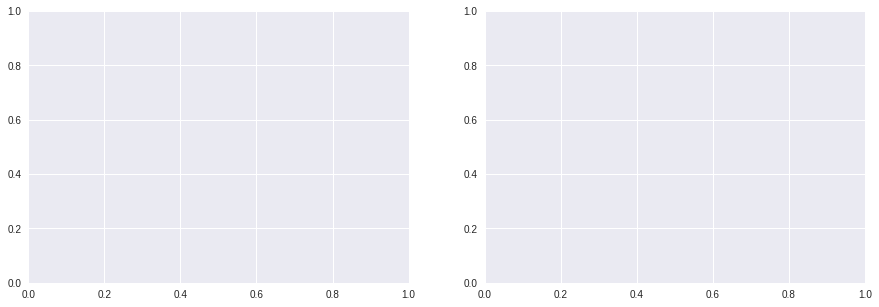

In [44]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 2,figsize=(15, 5))
fig.suptitle(tickers.Symbol[index],fontsize = 20)

# Plot de la RNN 16-8
ax1.plot(history_LSTM168.epoch,history_LSTM168.history['val_porcentaje_margen'],label='validation')
ax1.plot(history_LSTM168.epoch,history_LSTM168.history['porcentaje_margen'],label="training")
ax1.legend()
ax1.set_title('Success Rate Evolution 16-8')
ax1.set_xlabel('Epocs')
ax1.annotate('Val_Success_final = %.3f'% history_LSTM168.history['val_porcentaje_margen'][-1], (1250, 0.2), xytext=(-80, 0), 
            textcoords='offset points',fontsize = 10)


# Plot de la RNN 10-5
ax2.plot(history_LSTM105.epoch,history_LSTM105.history['val_porcentaje_margen'],label='validation')
ax2.plot(history_LSTM105.epoch,history_LSTM105.history['porcentaje_margen'],label="training")
ax2.legend()
ax2.set_title('Success Rate Evolution 10-5')
ax2.set_xlabel('Epocs')
ax2.annotate('Val_Success_final = %.3f'% history_LSTM105.history['val_porcentaje_margen'][-1], (1250, 0.2), xytext=(-80, 0), 
            textcoords='offset points',fontsize = 10)

plt.show()

In [49]:
# Calculo la prediccion para mi conjunto test
predictedLSTM105 = pd.DataFrame(model105.predict(Xtt))
predictedLSTM168 = pd.DataFrame(model168.predict(Xtt))

# Junto la grafica de los datos de entrenamiento y test para ver cuanto a variado en terminos generales
indicedetiempo = pd.concat((index_time,index_time_t), axis = 0)
yt = pd.DataFrame(yt) ; ytt = pd.DataFrame(ytt)
stock_real_value = pd.concat((yt,ytt),axis = 0)

# Calculo el RMSE para ver el error de prediccion
rmseLSTM105 = sqrt(mean_squared_error(ytt, predictedLSTM105))
rmseLSTM168 = sqrt(mean_squared_error(ytt, predictedLSTM168))
print(rmseLSTM105,rmseLSTM168)

32.45290630403061 54.360798339110026


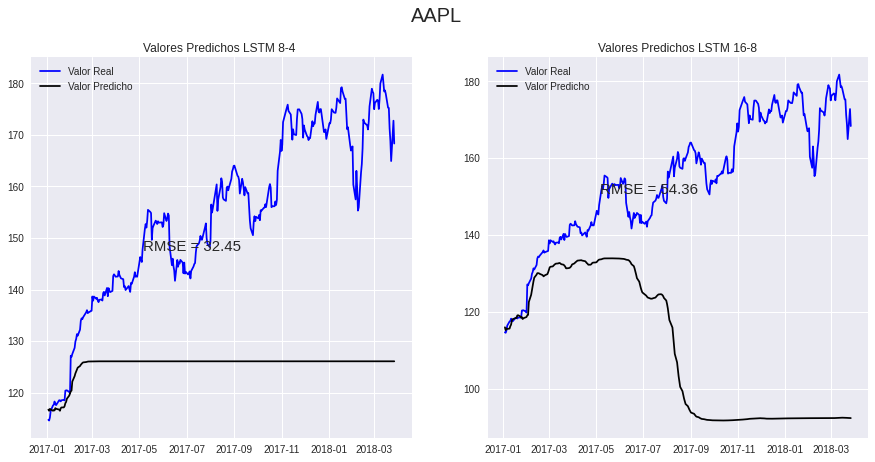

In [50]:
fig, axes = plt.subplots(1, 2,figsize=(15, 7))
fig.suptitle(tickers.Symbol[index],fontsize = 20)

# Plot de la LSTM 10-5
axes[0].plot(index_time_t,ytt,label="Valor Real",color = "blue")
axes[0].plot(index_time_t,predictedLSTM105, label="Valor Predicho", color = "black")
axes[0].legend()
axes[0].set_title('Valores Predichos LSTM 8-4 ')
axes[0].annotate('RMSE = %.2f'% rmseLSTM105, (index_time_t[40], ytt.iloc[40]), xytext=(50, 50), 
            textcoords='offset points',fontsize = 15)

# Plot de la LSTM 16-8
axes[1].plot(index_time_t,ytt,label="Valor Real",color = "blue")
axes[1].plot(index_time_t,predictedLSTM168, label="Valor Predicho", color = "black")
axes[1].legend()
axes[1].set_title('Valores Predichos LSTM 16-8')
axes[1].annotate('RMSE = %.2f'% rmseLSTM168, (index_time_t[40], ytt.iloc[40]), xytext=(50, 50), 
            textcoords='offset points',fontsize = 15)




plt.show()

Queremos realizar una inversion de 100000 euros en el activo que hemos estudiado, nos basamos en un margen entre la diferencia de los dos precios adyacentes para saber si comprar, vender o mantener.
Tenemos 3 posibles caminos, comprar solo a la alza, comprar solo a la baja o comprar a la alza y a la baja.
Ciertos actios tienen caidas o subidas muy bruscas imposibles de predecir porque no tienen que ver con los datos historicos si no con la situacion y el contexto que vive la empresa

In [137]:
pd.options.display.max_rows = 10000 # Para poder ver todos los movimientos
predicted_stock_price = predictedR
# Es un margen movil, segun lo que busquemos
margen = 0.00
diferencias = np.zeros(len(predicted_stock_price)-1)
for i in range(len(diferencias)):
    diferencias[i] = (predicted_stock_price.iloc[i+1,0]-predicted_stock_price.iloc[i,0])/max(predicted_stock_price.iloc[i+1,0],predicted_stock_price.iloc[i,0])
    if diferencias[i] > margen:
        diferencias[i] = 1
    elif diferencias[i] < -margen:
        diferencias[i] = -1
    else:
        diferencias[i] = 0
    
print(Counter(diferencias))

Counter({1.0: 160, -1.0: 149})


In [138]:
# Si solo queremos comrpar a la alza
# Estado es lo que hay que hacer ese dia
# estado = 1 comprar, estado = 0 mantener, estado = -1 vender
movimientos_alza = pd.DataFrame(columns = ["presupuesto","acciones","estado","valor","pred","dif"],index = index_time_t)
movimientos_alza.presupuesto[0] = 100000 ; movimientos_alza.acciones[0] = 0 ; movimientos_alza.estado[0] = 0
movimientos_alza.valor[0] = ytt.iloc[0,0] ; movimientos_alza.pred[0] = predicted_stock_price.iloc[0,0]

for i in range(1,len(diferencias)):
    if diferencias[i] == 1:
        if movimientos_alza.acciones[i-1] == 0:
            movimientos_alza.estado[i] = 1
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1] % ytt.iloc[i,0]
            movimientos_alza.acciones[i] = movimientos_alza.presupuesto[i-1] // ytt.iloc[i,0]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
        else:
            movimientos_alza.estado[i] = 0
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1]
            movimientos_alza.acciones[i] = movimientos_alza.acciones[i-1]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
    elif diferencias[i] == 0:
            movimientos_alza.estado[i] = 0
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1]
            movimientos_alza.acciones[i] = movimientos_alza.acciones[i-1]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
    elif diferencias[i] == -1:
        if movimientos_alza.acciones[i-1] > 0:
            movimientos_alza.estado[i] = -1
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1] + movimientos_alza.acciones[i-1] * ytt.iloc[i,0]
            movimientos_alza.acciones[i] = 0
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
        else:
            movimientos_alza.estado[i] = 0
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1]
            movimientos_alza.acciones[i] = movimientos_alza.acciones[i-1]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]

            
movimientos_alza = movimientos_alza.drop(movimientos_alza.tail(1).index)
print(movimientos_alza.tail(1))
valor_f_alza = movimientos_alza.presupuesto[len(movimientos_alza)-1] + movimientos_alza.valor[len(movimientos_alza)-1] * movimientos_alza.acciones[len(movimientos_alza)-1]
ganancia_alza = valor_f_alza - 100000
print('Valor Final = %.2f' % valor_f_alza)
print('Ganancia con margen = %.2f' % ganancia_alza)

           presupuesto acciones estado  valor     pred dif
2018-03-26      132773        0      0  44.35  42.4567  -1
Valor Final = 132772.56
Ganancia con margen = 32772.56


In [44]:
print(movimientos_alza)

           presupuesto acciones acciones_debo estado    valor     pred  dif
2016-12-30      100000        0             0      0     38.3  43.1799  NaN
2017-01-03      199972        0          2568     -1    38.93   43.227   -1
2017-01-04      199972        0          2568      0    39.66  42.9557   -1
2017-01-05       99923        0             0      1    38.96  42.5517    1
2017-01-06      199833        0          2587     -1    38.62  43.4381   -1
2017-01-09      199833        0          2587      0    38.45  43.3545   -1
2017-01-10      199833        0          2587      0    38.36  43.0065   -1
2017-01-11      199833        0          2587      0       39  42.6662   -1
2017-01-12      199833        0          2587      0    38.52  42.4598   -1
2017-01-13      199833        0          2587      0    38.81  42.3253   -1
2017-01-17      199833        0          2587      0     37.8  42.1163   -1
2017-01-18      199833        0          2587      0    37.95  41.9717   -1
2017-01-19  

In [139]:
# Compro a la alza y a la baja
# movimiento que se realizao en el dia = estado
# estado = 1 comprar, estado = 0 mantener, estado = -1 vender
movimientos_ab= pd.DataFrame(columns = ["presupuesto","acciones","acciones_debo","estado","valor","pred","dif"],index = index_time_t)
movimientos_ab.presupuesto[0] = 100000 % ytt.iloc[0,0] ; movimientos_ab.acciones[0] = 100000 // ytt.iloc[0,0] ; movimientos_ab.acciones_debo[0] = 0 ;
movimientos_ab.estado[0] = 0 ; movimientos_ab.valor[0] = ytt.iloc[0,0] ;
movimientos_ab.pred[0] = predicted_stock_price.iloc[0,0] 

for i in range(1,len(diferencias)):
    if diferencias[i] == 1:
        if movimientos_ab.acciones[i-1] == 0:
            movimientos_ab.estado[i] = 1
            movimientos_ab.presupuesto[i] = ((movimientos_ab.presupuesto[i-1] - (movimientos_ab.acciones_debo[i-1] * ytt.iloc[i,0]))
                                         % ytt.iloc[i,0])
            movimientos_ab.acciones[i] = ((movimientos_ab.presupuesto[i-1] - (movimientos_ab.acciones_debo[i-1] * ytt.iloc[i,0]))
                                         // ytt.iloc[i,0])
            movimientos_ab.acciones_debo[i] = 0
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
        else:
            movimientos_ab.estado[i] = 0
            movimientos_ab.presupuesto[i] = movimientos_ab.presupuesto[i-1]
            movimientos_ab.acciones[i] = movimientos_ab.acciones[i-1]
            movimientos_ab.acciones_debo[i] = movimientos_ab.acciones_debo[i-1]
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
    elif diferencias[i] == 0:
            movimientos_ab.estado[i] = 0
            movimientos_ab.presupuesto[i] = movimientos_ab.presupuesto[i-1]
            movimientos_ab.acciones[i] = movimientos_ab.acciones[i-1]
            movimientos_ab.acciones_debo[i] = movimientos_ab.acciones_debo[i-1]
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
    elif diferencias[i] == -1:
        if movimientos_ab.acciones_debo[i-1] == 0:
            movimientos_ab.estado[i] = -1
            movimientos_ab.presupuesto[i] = ((movimientos_ab.presupuesto[i-1] + movimientos_ab.acciones[i-1] * ytt.iloc[i,0]) +
                                          ((movimientos_ab.presupuesto[i-1] + movimientos_ab.acciones[i-1] * ytt.iloc[i,0]) //
                                           ytt.iloc[i,0]) * ytt.iloc[i,0])
            movimientos_ab.acciones[i] = 0
            movimientos_ab.acciones_debo[i] = ((movimientos_ab.presupuesto[i-1] + movimientos_ab.acciones[i-1] * ytt.iloc[i,0]) //
                                           ytt.iloc[i,0]) # Las pido prestadas
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
        else:
            movimientos_ab.estado[i] = 0
            movimientos_ab.presupuesto[i] = movimientos_ab.presupuesto[i-1]
            movimientos_ab.acciones[i] = movimientos_ab.acciones[i-1]
            movimientos_ab.acciones_debo[i] = movimientos_ab.acciones_debo[i-1]
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
            
movimientos_ab = movimientos_ab.drop(movimientos_ab.tail(1).index)
print(movimientos_ab.tail(1))
if movimientos_ab.acciones_debo[len(movimientos_ab)-1] == 0 :
    valor_f_ab = movimientos_ab.presupuesto[len(movimientos_ab)-1] + movimientos_ab.valor[len(movimientos_ab)-1] * movimientos_ab.acciones[len(movimientos_ab)-1]
else:
    valor_f_ab = movimientos_ab.presupuesto[len(movimientos_ab)-1] - movimientos_ab.valor[len(movimientos_ab)-1] * movimientos_ab.acciones_debo[len(movimientos_ab)-1]
ganancia_ab = valor_f_ab - 100000
print('Valor Final = %.2f' % valor_f_ab)
print('Ganancia con margen = %.2f' % ganancia_ab)

           presupuesto acciones acciones_debo estado  valor     pred dif
2018-03-26      233283        0          2703      0  44.35  42.4567  -1
Valor Final = 113404.90
Ganancia con margen = 13404.90


In [50]:
print(movimientos_ab)

            presupuesto     acciones acciones_debo estado    valor     pred  \
2016-12-30           37         2610             0      0     38.3  42.7767   
2017-01-03       203252            0          2610     -1    38.93  42.6769   
2017-01-04       203252            0          2568      0    39.66  42.2528   
2017-01-05        36.24         2648             0      1    38.96  41.5931   
2017-01-06        36.24         2648             0      0    38.62  42.4012   
2017-01-09       203667            0          2648     -1    38.45  42.4629   
2017-01-10       203667            0          2587      0    38.36  42.2726   
2017-01-11       203667            0          2587      0       39  42.0309   
2017-01-12       203667            0          2587      0    38.52  41.9139   
2017-01-13       203667            0          2587      0    38.81  41.8959   
2017-01-17       203667            0          2587      0     37.8  41.7773   
2017-01-18       203667            0          2587  

In [140]:
# Compro a la baja
# movimiento que se realizao en el dia = estado
# estado = 1 comprar, estado = 0 mantener, estado = -1 vender
movimientos_baja = pd.DataFrame(columns = ["presupuesto","acciones","acciones_debo","estado","valor","pred","dif"],index = index_time_t)
movimientos_baja.presupuesto[0] = 100000  ; movimientos_baja.acciones[0] = 0 ; movimientos_baja.acciones_debo[0] = 0 ;
movimientos_baja.estado[0] = 0 ; movimientos_baja.valor[0] = ytt.iloc[0,0] ;
movimientos_baja.pred[0] = predicted_stock_price.iloc[0,0] 

for i in range(1,len(diferencias)):
    if diferencias[i] == 1:
        if movimientos_baja.acciones[i-1] == 0:
            movimientos_baja.estado[i] = 1
            movimientos_baja.presupuesto[i] = ((movimientos_baja.presupuesto[i-1] - (movimientos_baja.acciones_debo[i-1] * ytt.iloc[i,0])))
            movimientos_baja.acciones[i] = 0
            movimientos_baja.acciones_debo[i] = 0
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
        else:
            movimientos_baja.estado[i] = 0
            movimientos_baja.presupuesto[i] = movimientos_baja.presupuesto[i-1]
            movimientos_baja.acciones[i] = movimientos_baja.acciones[i-1]
            movimientos_baja.acciones_debo[i] = movimientos_baja.acciones_debo[i-1]
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
    elif diferencias[i] == 0:
            movimientos_baja.estado[i] = 0
            movimientos_baja.presupuesto[i] = movimientos_baja.presupuesto[i-1]
            movimientos_baja.acciones[i] = movimientos_baja.acciones[i-1]
            movimientos_baja.acciones_debo[i] = movimientos_baja.acciones_debo[i-1]
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
    elif diferencias[i] == -1:
        if movimientos_baja.acciones_debo[i-1] == 0:
            movimientos_baja.estado[i] = -1
            movimientos_baja.presupuesto[i] = ((movimientos_baja.presupuesto[i-1]) + (movimientos_baja.presupuesto[i-1] //
                                           ytt.iloc[i,0]) * ytt.iloc[i,0])
            movimientos_baja.acciones[i] = 0
            movimientos_baja.acciones_debo[i] = (movimientos_baja.presupuesto[i-1] // ytt.iloc[i,0]) # Las pido prestadas
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
        else:
            movimientos_baja.estado[i] = 0
            movimientos_baja.presupuesto[i] = movimientos_baja.presupuesto[i-1]
            movimientos_baja.acciones[i] = movimientos_baja.acciones[i-1]
            movimientos_baja.acciones_debo[i] = movimientos_baja.acciones_debo[i-1]
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
            
movimientos_baja = movimientos_baja.drop(movimientos_baja.tail(1).index)
print(movimientos_baja.tail(1))
if movimientos_baja.acciones_debo[len(movimientos_baja)-1] == 0 :
    valor_f_baja = movimientos_baja.presupuesto[len(movimientos_baja)-1] + movimientos_baja.valor[len(movimientos_baja)-1] * movimientos_baja.acciones_debo[len(movimientos_baja)-1]
else:
    valor_f_baja = movimientos_baja.presupuesto[len(movimientos_baja)-1] - movimientos_baja.valor[len(movimientos_baja)-1] * movimientos_baja.acciones_debo[len(movimientos_baja)-1]
ganancia_baja = valor_f_baja - 100000
print('Valor Final = %.2f' % valor_f_baja)
print('Ganancia con margen = %.2f' % ganancia_baja)

           presupuesto acciones acciones_debo estado  valor     pred dif
2018-03-26      174259        0          2019      0  44.35  42.4567  -1
Valor Final = 84716.80
Ganancia con margen = -15283.20


In [53]:
print(movimientos_baja)

           presupuesto acciones acciones_debo estado    valor     pred  dif
2016-12-30      100000        0             0      0     38.3  43.1799  NaN
2017-01-03      199972        0          2568     -1    38.93   43.227   -1
2017-01-04      199972        0          2568      0    39.66  42.9557   -1
2017-01-05       99923        0             0      1    38.96  42.5517    1
2017-01-06      199833        0          2587     -1    38.62  43.4381   -1
2017-01-09      199833        0          2587      0    38.45  43.3545   -1
2017-01-10      199833        0          2587      0    38.36  43.0065   -1
2017-01-11      199833        0          2587      0       39  42.6662   -1
2017-01-12      199833        0          2587      0    38.52  42.4598   -1
2017-01-13      199833        0          2587      0    38.81  42.3253   -1
2017-01-17      199833        0          2587      0     37.8  42.1163   -1
2017-01-18      199833        0          2587      0    37.95  41.9717   -1
2017-01-19  